# Загрузка и первичный препроцессинг данных

In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from my_functions import *

import logging
import datetime

from sklearn.metrics import r2_score, mean_squared_error, \
    mean_absolute_error, median_absolute_error, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_roc_curve

import numpy as np
import seaborn as sns

import itertools
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

#Библиотека sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle #метод shuffle для перемешивания данных
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

#Модели библиотеки LGBM
from lightgbm import LGBMClassifier

#Модели библиотеки Catboost
#pip install catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Set notebook style in HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df_list = []
for fpath in ['../data/agents2019.csv', '../data/agents2020.csv', '../data/agents2021.csv']:
    df_list.append(pd.read_csv(fpath))

In [4]:
df_list[0]

,Unnamed: 0,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB","2018, Основные средства , RUB","2016, Внеоборотные активы, RUB","2017, Внеоборотные активы, RUB","2018, Внеоборотные активы, RUB","2016, Дебиторская задолженность, RUB","2017, Дебиторская задолженность, RUB","2018, Дебиторская задолженность, RUB","2016, Оборотные активы, RUB","2017, Оборотные активы, RUB","2018, Оборотные активы, RUB","2016, Уставный капитал , RUB","2017, Уставный капитал , RUB","2018, Уставный капитал , RUB","2016, Капитал и резервы, RUB","2017, Капитал и резервы, RUB","2018, Капитал и резервы, RUB","2016, Заёмные средства (долгосрочные), RUB","2017, Заёмные средства (долгосрочные), RUB","2018, Заёмные средства (долгосрочные), RUB","2016, Долгосрочные обязательства, RUB","2017, Долгосрочные обязательства, RUB","2018, Долгосрочные обязательства, RUB","2016, Заёмные средства (краткосрочные), RUB","2017, Заёмные средства (краткосрочные), RUB","2018, Заёмные средства (краткосрочные), RUB","2016, Кредиторская задолженность, RUB","2017, Кредиторская задолженность, RUB","2018, Кредиторская задолженность, RUB","2016, Краткосрочные обязательства, RUB","2017, Краткосрочные обязательства, RUB","2018, Краткосрочные обязательства, RUB","2016, Выручка, RUB","2017, Выручка, RUB","2018, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB"
0,0,0,0,0.0,0,0.000000,0,2.895541e+06,6.245860e+06,9.050955e+06,1.889724e+09,1.803724e+09,2.145239e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.583766e+09,3.683359e+09,3.475461e+09,5.159380e+09,5.897326e+09,6.077448e+09,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,0.000000e+00,0.000000e+00,3.923917e+08,4.080056e+09,4.452922e+09,5.476906e+09,4.165168e+09,4.548178e+09,5.957031e+09,2.667698e+10,4.162693e+10,3.703952e+10,2.156814e+10,3.335443e+10,3.438313e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.280355e+09,6.200120e+09,8.716191e+08
1,1,1,0,0.0,0,0.000000,0,0.000000e+00,3.885350e+04,3.439490e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.456783e+08,1.497987e+08,1.538924e+08,5.584777e+07,4.678217e+07,1.563478e+08,1.489153e+08,1.898987e+08,2.914637e+08,1.345860e+06,1.345860e+06,1.345860e+06,2.726650e+08,2.774083e+08,3.106586e+08,0.000000e+00,0.000000e+00,0.000000e+00,3.108280e+06,4.528025e+06,5.033758e+06,9.745223e+06,4.760637e+07,6.349873e+07,9.075159e+06,1.015478e+07,6.616497e+07,1.882038e+07,5.776115e+07,1.296637e+08,2.554898e+08,2.573669e+08,5.434306e+08,2.056815e+08,2.055325e+08,4.169796e+08,1.212357e+07,6.944586e+06,4.480064e+07,1.630064e+07,1.109172e+07,5.135732e+07
2,2,2,7,5.5,1,132825.299363,2,2.468153e+06,1.288025e+07,8.694904e+06,9.698064e+08,9.444166e+08,9.287389e+08,9.732745e+08,1.036412e+09,1.018682e+09,2.814675e+08,2.321070e+08,2.280497e+08,1.286917e+09,1.489083e+09,1.590217e+09,1.964459e+07,1.964459e+07,1.964459e+07,2.110425e+09,2.339440e+09,2.378698e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.339809e+07,1.183121e+07,2.843949e+06,0.000000e+00,0.000000e+00,0.000000e+00,8.246879e+07,8.857197e+07,1.237713e+08,1.363688e+08,1.742242e+08,2.273567e+08,2.786577e+09,2.699397e+09,2.592420e+09,2.038076e+09,2.178598e+09,2.316724e+09,5.026662e+08,3.644229e+08,8.552994e+07,4.148586e+08,1.611318e+08,-9.298981e+07
3,3,3,0,0.0,0,0.000000,0,0.000000e+00,0.000000e+00,0.0

## Препроцессинг данных за 2021 год

In [5]:
df_2021 = df_list[2].copy()

In [6]:
df_2021 = df_2021.drop(columns=['Unnamed: 0'])
df_2021.index = df_2021['Наименование ДП']
rename_dict = {'Факт.32':'Факт 32',
               'Факт.31':'Факт 31',
            'Факт.23':'Факт 23'}
df_2021 = df_2021.rename(columns=rename_dict)
df_2021 = rename_cols(df_2021)

In [7]:
df_2021['кол_во_раз_пдз_за_2021_год_шт'] = 0
for idx in df_2021.index:
    for col_name in ['пдз_1_30', 'пдз_31_90', 'пдз_91_365', 'пдз_более_365']:
        df_2021.loc[idx,'кол_во_раз_пдз_за_2021_год_шт'] += df_2021.loc[idx,col_name]

## Подготовка объединеных данных за 3 года

In [8]:
df_total = join_data(df_list)
df_total

206


,наименование_дп,макс_пдз_за_2019_год_дней,сред_пдз_за_2019_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_2019_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_2019_год_руб,кол_во_раз_пдз_за_2019_год_шт,макс_пдз_за_2020_год_дней,сред_пдз_за_2020_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_2020_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_2020_год_руб,кол_во_раз_пдз_за_2020_год_шт,2021_оценка_потенциала_контрагента_1_руб,2021_оценка_потенциала_контрагента_2_руб,2021_статус,2016_нематериальные_активы_rub,2017_нематериальные_активы_rub,2018_нематериальные_активы_rub,2019_нематериальные_активы_rub,2020_нематериальные_активы_rub,2016_основные_средства__rub,2017_основные_средства__rub,2018_основные_средства__rub,2019_основные_средства__rub,2020_основные_средства__rub,2016_внеоборотные_активы_rub,2017_внеоборотные_активы_rub,2018_внеоборотные_активы_rub,2019_внеоборотные_активы_rub,2020_внеоборотные_активы_rub,2016_дебиторская_задолженность_rub,2017_дебиторская_задолженность_rub,2018_дебиторская_задолженность_rub,2019_дебиторская_задолженность_rub,2020_дебиторская_задолженность_rub,2016_оборотные_активы_rub,2017_оборотные_активы_rub,2018_оборотные_активы_rub,2019_оборотные_активы_rub,2020_оборотные_активы_rub,2016_уставный_капитал__rub,2017_уставный_капитал__rub,2018_уставный_капитал__rub,2019_уставный_капитал__rub,2020_уставный_капитал__rub,2016_капитал_и_резервы_rub,2017_капитал_и_резервы_rub,2018_капитал_и_резервы_rub,2019_капитал_и_резервы_rub,2020_капитал_и_резервы_rub,2016_заёмные_средства_долгосрочные_rub,2017_заёмные_средства_долгосрочные_rub,2018_заёмные_средства_долгосрочные_rub,2019_заёмные_средства_долгосрочные_rub,2020_заёмные_средства_долгосрочные_rub,2016_долгосрочные_обязательства_rub,2017_долгосрочные_обязательства_rub,2018_долгосрочные_обязательства_rub,2019_долгосрочные_обязательства_rub,2020_долгосрочные_обязательства_rub,2016_заёмные_средства_краткосрочные_rub,2017_заёмные_средства_краткосрочные_rub,2018_заёмные_средства_краткосрочные_rub,2019_заёмные_средства_краткосрочные_rub,2020_заёмные_средства_краткосрочные_rub,2016_кредиторская_задолженность_rub,2017_кредиторская_задолженность_rub,2018_кредиторская_задолженность_rub,2019_кредиторская_задолженность_rub,2020_кредиторская_задолженность_rub,2016_краткосрочные_обязательства_rub,2017_краткосрочные_обязательства_rub,2018_краткосрочные_обязательства_rub,2019_краткосрочные_обязательства_rub,2020_краткосрочные_обязательства_rub,2016_выручка_rub,2017_выручка_rub,2018_выручка_rub,2019_выручка_rub,2020_выручка_rub,2016_себестоимость_продаж_rub,2017_себестоимость_продаж_rub,2018_себестоимость_продаж_rub,2019_себестоимость_продаж_rub,2020_себестоимость_продаж_rub,2016_прибыль_убыток_до_налогообложения__rub,2017_прибыль_убыток_до_налогообложения__rub,2018_прибыль_убыток_до_налогообложения__rub,2019_прибыль_убыток_до_налогообложения__rub,2020_прибыль_убыток_до_налогообложения__rub,2016_прибыль_убыток_от_продажи_rub,2017_прибыль_убыток_от_продажи_rub,2018_прибыль_убыток_от_продажи_rub,2019_прибыль_убыток_от_продажи_rub,2020_прибыль_убыток_от_продажи_rub,2021_факт_20,2021_факт_21,2021_факт_32,2021_факт_31,2021_факт_23,2021_факт_24,2021_факт_27,2021_факт_33,2021_факт_28,2021_факт_29,2021_факт_30,2021_факт_40,2021_факт_41,2021_факт_42,2021_факт_46,2021_факт_48,2021_факт_49,2021_факт_50,2021_факт_51,2021_факт_54,2021_факт_55,2021_факт_56,2021_факт_57,2021_факт_58,2021_факт_59,2021_факт_60,2021_факт_37,2021_факт_39,2021_факт_1,2021_факт_2,2021_факт_3,2021_факт_7,2021_факт_12,2021_факт_14,2021_факт_15,2021_факт_16,2021_итого,2021_пдз_1_30,2021_пдз_31_90,2021_пдз_91_365,2021_пдз_более_365,кол_во_раз_пдз_за_2021_год_шт,2020_факт_1,2020_факт_2,2020_факт_3,2020_факт_4,2020_факт_5,2020_факт_6,2020_факт_7,2020_факт_8,2020_факт_9,2020_факт_10,2020_факт_11,2020_факт_12,2020_факт_13,2020_факт_14,2020_факт_15,2020_факт_16,2020_факт_17,2020_факт_18,2020_факт_19,2020_факт_20,2020_факт_21,2020_факт_22,2020_факт_23,2020_факт_24,2020_факт_25,2020_факт_26,2020_факт_27,2020_факт_28,2020_факт_29,2020_факт_3

In [9]:
#Генерация оборачиваемости дебиторской задолженности (год_ОДЗ)
df_total['2020_одз'] = (2*df_total['2020_выручка_rub'] /(df_total['2019_дебиторская_задолженность_rub'] + df_total['2020_дебиторская_задолженность_rub']))

df_total['2019_одз'] = (2*df_total['2019_выручка_rub'] /(df_total['2018_дебиторская_задолженность_rub'] + df_total['2019_дебиторская_задолженность_rub']))

df_total['2018_одз'] = (2*df_total['2018_выручка_rub'] /(df_total['2017_дебиторская_задолженность_rub'] + df_total['2018_дебиторская_задолженность_rub']))

df_total['2017_одз'] = (2*df_total['2017_выручка_rub'] /(df_total['2016_дебиторская_задолженность_rub'] + df_total['2017_дебиторская_задолженность_rub']))

#Генерация периода погошения дебиторской задолженности (год_пгдз)
df_total['2020_пгдз'] = 360 / df_total['2020_одз']
df_total['2019_пгдз'] = 360 / df_total['2019_одз']
df_total['2017_пгдз'] = 360 / df_total['2018_одз']
df_total['2018_пгдз'] = 360 / df_total['2017_одз']

#Генерация признака доля дебиторской задолженности в оборотных активах (год_ддзоа)
df_total['2020_ддзоа'] = df_total['2020_дебиторская_задолженность_rub'] / df_total['2020_оборотные_активы_rub']
df_total['2019_ддзоа'] = df_total['2019_дебиторская_задолженность_rub'] / df_total['2019_оборотные_активы_rub']
df_total['2018_ддзоа'] = df_total['2018_дебиторская_задолженность_rub'] / df_total['2018_оборотные_активы_rub']
df_total['2017_ддзоа'] = df_total['2017_дебиторская_задолженность_rub'] / df_total['2017_оборотные_активы_rub']
df_total['2016_ддзоа'] = df_total['2016_дебиторская_задолженность_rub'] / df_total['2016_оборотные_активы_rub']


#Пятифакторная модель Альтамана для компаний (оценка банкротсвта)
#X1 = Оборотный капитал / Активы = (оборотные_активы_rub - краткосрочные_обязательства_rub) / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X2 = Нераспределенная прибыль(Чистая прибыль) / Активы = прибыль_убыток_от_продажи_rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X3 = Операционная прибыль(Прибыль до налогообложения) / Активы = прибыль_убыток_до_налогообложения__rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X4 = Балансовая стоимость собственного капитала / Заёмный капитал = (уставный_капитал__rub + прибыль_убыток_от_продажи_rub) / (заёмные_средства_долгосрочные_rub + заёмные_средства_краткосрочные_rub)
#X5 = Выручка / Активы = выручка_rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)

#Vодель Альтамана для компаний 2016 год
AKTIVS = (df_total['2016_внеоборотные_активы_rub'] + df_total['2016_оборотные_активы_rub'] + df_total['2016_нематериальные_активы_rub'])

X1 = (df_total['2016_оборотные_активы_rub'] - df_total['2016_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_total['2016_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_total['2016_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_total['2016_уставный_капитал__rub'] + df_total['2016_прибыль_убыток_от_продажи_rub']) / (df_total['2016_заёмные_средства_долгосрочные_rub'] + df_total['2016_заёмные_средства_краткосрочные_rub'])
X5 = df_total['2016_выручка_rub'] / AKTIVS

df_total['2016_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Модель Альтамана для компаний 2017 год
AKTIVS = (df_total['2017_внеоборотные_активы_rub'] + df_total['2017_оборотные_активы_rub'] + df_total['2017_нематериальные_активы_rub'])

X1 = (df_total['2017_оборотные_активы_rub'] - df_total['2017_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_total['2017_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_total['2017_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_total['2017_уставный_капитал__rub'] + df_total['2017_прибыль_убыток_от_продажи_rub']) / (df_total['2017_заёмные_средства_долгосрочные_rub'] + df_total['2017_заёмные_средства_краткосрочные_rub'])
X5 = df_total['2017_выручка_rub'] / AKTIVS

df_total['2017_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Модель Альтамана для компаний 2018 год
AKTIVS = (df_total['2018_внеоборотные_активы_rub'] + df_total['2018_оборотные_активы_rub'] + df_total['2018_нематериальные_активы_rub'])

X1 = (df_total['2018_оборотные_активы_rub'] - df_total['2018_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_total['2018_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_total['2018_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_total['2018_уставный_капитал__rub'] + df_total['2018_прибыль_убыток_от_продажи_rub']) / (df_total['2018_заёмные_средства_долгосрочные_rub'] + df_total['2018_заёмные_средства_краткосрочные_rub'])
X5 = df_total['2018_выручка_rub'] / AKTIVS

df_total['2018_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Модель Альтамана для компаний 2019 год
AKTIVS = (df_total['2019_внеоборотные_активы_rub'] + df_total['2019_оборотные_активы_rub'] + df_total['2019_нематериальные_активы_rub'])

X1 = (df_total['2019_оборотные_активы_rub'] - df_total['2019_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_total['2019_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_total['2019_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_total['2019_уставный_капитал__rub'] + df_total['2019_прибыль_убыток_от_продажи_rub']) / (df_total['2019_заёмные_средства_долгосрочные_rub'] + df_total['2019_заёмные_средства_краткосрочные_rub'])
X5 = df_total['2019_выручка_rub'] / AKTIVS

df_total['2019_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Модель Альтамана для компаний 2020 год
AKTIVS = (df_total['2020_внеоборотные_активы_rub'] + df_total['2020_оборотные_активы_rub'] + df_total['2020_нематериальные_активы_rub'])

X1 = (df_total['2020_оборотные_активы_rub'] - df_total['2020_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_total['2020_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_total['2020_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_total['2020_уставный_капитал__rub'] + df_total['2020_прибыль_убыток_от_продажи_rub']) / (df_total['2020_заёмные_средства_долгосрочные_rub'] + df_total['2020_заёмные_средства_краткосрочные_rub'])
X5 = df_total['2020_выручка_rub'] / AKTIVS

df_total['2016_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_total['2017_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_total['2018_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_total['2019_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_total['2020_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5

df_total = df_total.replace([np.inf, -np.inf], np.nan)

In [10]:
df_by_years_total = prepare_data_for_model(df_total)
df_by_years_total

,наименование_дп,макс_пдз_за_YY_2_год_дней,сред_пдз_за_YY_2_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_YY_2_год_руб,кол_во_раз_пдз_за_YY_2_год_шт,макс_пдз_за_YY_1_год_дней,сред_пдз_за_YY_1_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_YY_1_год_руб,кол_во_раз_пдз_за_YY_1_год_шт,оценка_потенциала_контрагента_1_руб,оценка_потенциала_контрагента_2_руб,статус,YY_5_нематериальные_активы_rub,YY_4_нематериальные_активы_rub,YY_3_нематериальные_активы_rub,YY_2_нематериальные_активы_rub,YY_1_нематериальные_активы_rub,YY_5_основные_средства__rub,YY_4_основные_средства__rub,YY_3_основные_средства__rub,YY_2_основные_средства__rub,YY_1_основные_средства__rub,YY_5_внеоборотные_активы_rub,YY_4_внеоборотные_активы_rub,YY_3_внеоборотные_активы_rub,YY_2_внеоборотные_активы_rub,YY_1_внеоборотные_активы_rub,YY_5_дебиторская_задолженность_rub,YY_4_дебиторская_задолженность_rub,YY_3_дебиторская_задолженность_rub,YY_2_дебиторская_задолженность_rub,YY_1_дебиторская_задолженность_rub,YY_5_оборотные_активы_rub,YY_4_оборотные_активы_rub,YY_3_оборотные_активы_rub,YY_2_оборотные_активы_rub,YY_1_оборотные_активы_rub,YY_5_уставный_капитал__rub,YY_4_уставный_капитал__rub,YY_3_уставный_капитал__rub,YY_2_уставный_капитал__rub,YY_1_уставный_капитал__rub,YY_5_капитал_и_резервы_rub,YY_4_капитал_и_резервы_rub,YY_3_капитал_и_резервы_rub,YY_2_капитал_и_резервы_rub,YY_1_капитал_и_резервы_rub,YY_5_заёмные_средства_долгосрочные_rub,YY_4_заёмные_средства_долгосрочные_rub,YY_3_заёмные_средства_долгосрочные_rub,YY_2_заёмные_средства_долгосрочные_rub,YY_1_заёмные_средства_долгосрочные_rub,YY_5_долгосрочные_обязательства_rub,YY_4_долгосрочные_обязательства_rub,YY_3_долгосрочные_обязательства_rub,YY_2_долгосрочные_обязательства_rub,YY_1_долгосрочные_обязательства_rub,YY_5_заёмные_средства_краткосрочные_rub,YY_4_заёмные_средства_краткосрочные_rub,YY_3_заёмные_средства_краткосрочные_rub,YY_2_заёмные_средства_краткосрочные_rub,YY_1_заёмные_средства_краткосрочные_rub,YY_5_кредиторская_задолженность_rub,YY_4_кредиторская_задолженность_rub,YY_3_кредиторская_задолженность_rub,YY_2_кредиторская_задолженность_rub,YY_1_кредиторская_задолженность_rub,YY_5_краткосрочные_обязательства_rub,YY_4_краткосрочные_обязательства_rub,YY_3_краткосрочные_обязательства_rub,YY_2_краткосрочные_обязательства_rub,YY_1_краткосрочные_обязательства_rub,YY_5_выручка_rub,YY_4_выручка_rub,YY_3_выручка_rub,YY_2_выручка_rub,YY_1_выручка_rub,YY_5_себестоимость_продаж_rub,YY_4_себестоимость_продаж_rub,YY_3_себестоимость_продаж_rub,YY_2_себестоимость_продаж_rub,YY_1_себестоимость_продаж_rub,YY_5_прибыль_убыток_до_налогообложения__rub,YY_4_прибыль_убыток_до_налогообложения__rub,YY_3_прибыль_убыток_до_налогообложения__rub,YY_2_прибыль_убыток_до_налогообложения__rub,YY_1_прибыль_убыток_до_налогообложения__rub,YY_5_прибыль_убыток_от_продажи_rub,YY_4_прибыль_убыток_от_продажи_rub,YY_3_прибыль_убыток_от_продажи_rub,YY_2_прибыль_убыток_от_продажи_rub,YY_1_прибыль_убыток_от_продажи_rub,факт_20,факт_21,факт_32,факт_31,факт_23,факт_24,факт_27,факт_33,факт_28,факт_29,факт_30,факт_40,факт_41,факт_42,факт_46,факт_48,факт_49,факт_50,факт_51,факт_54,факт_55,факт_56,факт_57,факт_58,факт_59,факт_60,факт_37,факт_39,факт_1,факт_2,факт_3,факт_7,факт_12,факт_14,факт_15,факт_16,итого,пдз_1_30,пдз_31_90,пдз_91_365,пдз_более_365,кол_во_раз_пдз_за_год_шт,YY_1_факт_1,YY_1_факт_2,YY_1_факт_3,YY_1_факт_4,YY_1_факт_5,YY_1_факт_6,YY_1_факт_7,YY_1_факт_8,YY_1_факт_9,YY_1_факт_10,YY_1_факт_11,YY_1_факт_12,YY_1_факт_13,YY_1_факт_14,YY_1_факт_15,YY_1_факт_16,YY_1_факт_17,YY_1_факт_18,YY_1_факт_19,YY_1_факт_20,YY_1_факт_21,YY_1_факт_22,YY_1_факт_23,YY_1_факт_24,YY_1_факт_25,YY_1_факт_26,YY_1_факт_27,YY_1_факт_28,YY_1_факт_29,YY_1_факт_30,YY_1_факт_31,YY_1_факт_32,YY_1_факт_33,YY_1_факт_34,YY_1_факт_35,YY_1_факт_36,YY_1_факт_37,YY_1_факт_38,YY_1_факт_39,YY_1_факт_40,YY_1_факт_41,YY_1_факт_42,YY_1_факт_43,YY_1_факт_44,YY_1_факт_45,YY_1_факт_46,YY_1_факт_47,YY

In [11]:
list(df_by_years_total.columns)

['наименование_дп',
 'макс_пдз_за_YY_2_год_дней',
 'сред_пдз_за_YY_2_год_дней',
 'кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт',
 'общая_сумма_пдз_свыше_5_ти_дней_за_YY_2_год_руб',
 'кол_во_раз_пдз_за_YY_2_год_шт',
 'макс_пдз_за_YY_1_год_дней',
 'сред_пдз_за_YY_1_год_дней',
 'кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт',
 'общая_сумма_пдз_свыше_5_ти_дней_за_YY_1_год_руб',
 'кол_во_раз_пдз_за_YY_1_год_шт',
 'оценка_потенциала_контрагента_1_руб',
 'оценка_потенциала_контрагента_2_руб',
 'статус',
 'YY_5_нематериальные_активы_rub',
 'YY_4_нематериальные_активы_rub',
 'YY_3_нематериальные_активы_rub',
 'YY_2_нематериальные_активы_rub',
 'YY_1_нематериальные_активы_rub',
 'YY_5_основные_средства__rub',
 'YY_4_основные_средства__rub',
 'YY_3_основные_средства__rub',
 'YY_2_основные_средства__rub',
 'YY_1_основные_средства__rub',
 'YY_5_внеоборотные_активы_rub',
 'YY_4_внеоборотные_активы_rub',
 'YY_3_внеоборотные_активы_rub',
 'YY_2_внеоборотные_активы_rub',
 'YY_1_внеоборотные_активы

In [12]:
df_by_years_total.describe()

,наименование_дп,макс_пдз_за_YY_2_год_дней,сред_пдз_за_YY_2_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_YY_2_год_руб,кол_во_раз_пдз_за_YY_2_год_шт,макс_пдз_за_YY_1_год_дней,сред_пдз_за_YY_1_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_YY_1_год_руб,кол_во_раз_пдз_за_YY_1_год_шт,оценка_потенциала_контрагента_1_руб,оценка_потенциала_контрагента_2_руб,YY_5_нематериальные_активы_rub,YY_4_нематериальные_активы_rub,YY_3_нематериальные_активы_rub,YY_2_нематериальные_активы_rub,YY_1_нематериальные_активы_rub,YY_5_основные_средства__rub,YY_4_основные_средства__rub,YY_3_основные_средства__rub,YY_2_основные_средства__rub,YY_1_основные_средства__rub,YY_5_внеоборотные_активы_rub,YY_4_внеоборотные_активы_rub,YY_3_внеоборотные_активы_rub,YY_2_внеоборотные_активы_rub,YY_1_внеоборотные_активы_rub,YY_5_дебиторская_задолженность_rub,YY_4_дебиторская_задолженность_rub,YY_3_дебиторская_задолженность_rub,YY_2_дебиторская_задолженность_rub,YY_1_дебиторская_задолженность_rub,YY_5_оборотные_активы_rub,YY_4_оборотные_активы_rub,YY_3_оборотные_активы_rub,YY_2_оборотные_активы_rub,YY_1_оборотные_активы_rub,YY_5_уставный_капитал__rub,YY_4_уставный_капитал__rub,YY_3_уставный_капитал__rub,YY_2_уставный_капитал__rub,YY_1_уставный_капитал__rub,YY_5_капитал_и_резервы_rub,YY_4_капитал_и_резервы_rub,YY_3_капитал_и_резервы_rub,YY_2_капитал_и_резервы_rub,YY_1_капитал_и_резервы_rub,YY_5_заёмные_средства_долгосрочные_rub,YY_4_заёмные_средства_долгосрочные_rub,YY_3_заёмные_средства_долгосрочные_rub,YY_2_заёмные_средства_долгосрочные_rub,YY_1_заёмные_средства_долгосрочные_rub,YY_5_долгосрочные_обязательства_rub,YY_4_долгосрочные_обязательства_rub,YY_3_долгосрочные_обязательства_rub,YY_2_долгосрочные_обязательства_rub,YY_1_долгосрочные_обязательства_rub,YY_5_заёмные_средства_краткосрочные_rub,YY_4_заёмные_средства_краткосрочные_rub,YY_3_заёмные_средства_краткосрочные_rub,YY_2_заёмные_средства_краткосрочные_rub,YY_1_заёмные_средства_краткосрочные_rub,YY_5_кредиторская_задолженность_rub,YY_4_кредиторская_задолженность_rub,YY_3_кредиторская_задолженность_rub,YY_2_кредиторская_задолженность_rub,YY_1_кредиторская_задолженность_rub,YY_5_краткосрочные_обязательства_rub,YY_4_краткосрочные_обязательства_rub,YY_3_краткосрочные_обязательства_rub,YY_2_краткосрочные_обязательства_rub,YY_1_краткосрочные_обязательства_rub,YY_5_выручка_rub,YY_4_выручка_rub,YY_3_выручка_rub,YY_2_выручка_rub,YY_1_выручка_rub,YY_5_себестоимость_продаж_rub,YY_4_себестоимость_продаж_rub,YY_3_себестоимость_продаж_rub,YY_2_себестоимость_продаж_rub,YY_1_себестоимость_продаж_rub,YY_5_прибыль_убыток_до_налогообложения__rub,YY_4_прибыль_убыток_до_налогообложения__rub,YY_3_прибыль_убыток_до_налогообложения__rub,YY_2_прибыль_убыток_до_налогообложения__rub,YY_1_прибыль_убыток_до_налогообложения__rub,YY_5_прибыль_убыток_от_продажи_rub,YY_4_прибыль_убыток_от_продажи_rub,YY_3_прибыль_убыток_от_продажи_rub,YY_2_прибыль_убыток_от_продажи_rub,YY_1_прибыль_убыток_от_продажи_rub,итого,пдз_1_30,пдз_31_90,пдз_91_365,пдз_более_365,кол_во_раз_пдз_за_год_шт,YY_1_итого,YY_1_одз,YY_2_одз,YY_3_одз,YY_4_одз,YY_1_пгдз,YY_2_пгдз,YY_4_пгдз,YY_3_пгдз,YY_1_ддзоа,YY_2_ддзоа,YY_3_ддзоа,YY_4_ддзоа,YY_5_ддзоа,YY_5_Z,YY_4_Z,YY_3_Z,YY_2_Z,YY_1_Z,YY,макс_пдз_за_год_дней,сред_пдз_за_год_дней,кол_во_просрочек_свыше_5_ти_дней_за_год_шт,общая_сумма_пдз_свыше_5_ти_дней_за_год_руб,нематериальные_активы_rub,основные_средства__rub,внеоборотные_активы_rub,дебиторская_задолженность_rub,оборотные_активы_rub,уставный_капитал__rub,капитал_и_резервы_rub,заёмные_средства_долгосрочные_rub,долгосрочные_обязательства_rub,заёмные_средства_краткосрочные_rub,кредиторская_задолженность_rub,краткосрочные_обязательства_rub,выручка_rub,себестоимость_продаж_rub,прибыль_убыток_до_налогообложения__rub,прибыль_убыток_от_продажи_rub,одз,пгдз,ддзоа,Z
count,1593.00000,531.000000,531.000000,531.000000,5.310000e+02,531.000000,856.000000,856.000000,856.000000,8.560000e+02,856.000000,3.

In [13]:
df_by_years_total = df_by_years_total.reindex(sorted(df_by_years_total.columns), axis=1)
df_by_years_total

,YY,YY_1_Z,YY_1_внеоборотные_активы_rub,YY_1_выручка_rub,YY_1_ддзоа,YY_1_дебиторская_задолженность_rub,YY_1_долгосрочные_обязательства_rub,YY_1_заёмные_средства_долгосрочные_rub,YY_1_заёмные_средства_краткосрочные_rub,YY_1_итого,YY_1_капитал_и_резервы_rub,YY_1_краткосрочные_обязательства_rub,YY_1_кредиторская_задолженность_rub,YY_1_нематериальные_активы_rub,YY_1_оборотные_активы_rub,YY_1_одз,YY_1_основные_средства__rub,YY_1_пгдз,YY_1_прибыль_убыток_до_налогообложения__rub,YY_1_прибыль_убыток_от_продажи_rub,YY_1_себестоимость_продаж_rub,YY_1_уставный_капитал__rub,YY_1_факт_1,YY_1_факт_10,YY_1_факт_11,YY_1_факт_12,YY_1_факт_13,YY_1_факт_14,YY_1_факт_15,YY_1_факт_16,YY_1_факт_17,YY_1_факт_18,YY_1_факт_19,YY_1_факт_2,YY_1_факт_20,YY_1_факт_21,YY_1_факт_22,YY_1_факт_23,YY_1_факт_24,YY_1_факт_25,YY_1_факт_26,YY_1_факт_27,YY_1_факт_28,YY_1_факт_29,YY_1_факт_3,YY_1_факт_30,YY_1_факт_31,YY_1_факт_32,YY_1_факт_33,YY_1_факт_34,YY_1_факт_35,YY_1_факт_36,YY_1_факт_37,YY_1_факт_38,YY_1_факт_39,YY_1_факт_4,YY_1_факт_40,YY_1_факт_41,YY_1_факт_42,YY_1_факт_43,YY_1_факт_44,YY_1_факт_45,YY_1_факт_46,YY_1_факт_47,YY_1_факт_48,YY_1_факт_49,YY_1_факт_5,YY_1_факт_50,YY_1_факт_51,YY_1_факт_52,YY_1_факт_53,YY_1_факт_54,YY_1_факт_55,YY_1_факт_56,YY_1_факт_57,YY_1_факт_58,YY_1_факт_59,YY_1_факт_6,YY_1_факт_60,YY_1_факт_7,YY_1_факт_8,YY_1_факт_9,YY_2_Z,YY_2_внеоборотные_активы_rub,YY_2_выручка_rub,YY_2_ддзоа,YY_2_дебиторская_задолженность_rub,YY_2_долгосрочные_обязательства_rub,YY_2_заёмные_средства_долгосрочные_rub,YY_2_заёмные_средства_краткосрочные_rub,YY_2_капитал_и_резервы_rub,YY_2_краткосрочные_обязательства_rub,YY_2_кредиторская_задолженность_rub,YY_2_нематериальные_активы_rub,YY_2_оборотные_активы_rub,YY_2_одз,YY_2_основные_средства__rub,YY_2_пгдз,YY_2_прибыль_убыток_до_налогообложения__rub,YY_2_прибыль_убыток_от_продажи_rub,YY_2_себестоимость_продаж_rub,YY_2_уставный_капитал__rub,YY_3_Z,YY_3_внеоборотные_активы_rub,YY_3_выручка_rub,YY_3_ддзоа,YY_3_дебиторская_задолженность_rub,YY_3_долгосрочные_обязательства_rub,YY_3_заёмные_средства_долгосрочные_rub,YY_3_заёмные_средства_краткосрочные_rub,YY_3_капитал_и_резервы_rub,YY_3_краткосрочные_обязательства_rub,YY_3_кредиторская_задолженность_rub,YY_3_нематериальные_активы_rub,YY_3_оборотные_активы_rub,YY_3_одз,YY_3_основные_средства__rub,YY_3_пгдз,YY_3_прибыль_убыток_до_налогообложения__rub,YY_3_прибыль_убыток_от_продажи_rub,YY_3_себестоимость_продаж_rub,YY_3_уставный_капитал__rub,YY_4_Z,YY_4_внеоборотные_активы_rub,YY_4_выручка_rub,YY_4_ддзоа,YY_4_дебиторская_задолженность_rub,YY_4_долгосрочные_обязательства_rub,YY_4_заёмные_средства_долгосрочные_rub,YY_4_заёмные_средства_краткосрочные_rub,YY_4_капитал_и_резервы_rub,YY_4_краткосрочные_обязательства_rub,YY_4_кредиторская_задолженность_rub,YY_4_нематериальные_активы_rub,YY_4_оборотные_активы_rub,YY_4_одз,YY_4_основные_средства__rub,YY_4_пгдз,YY_4_прибыль_убыток_до_налогообложения__rub,YY_4_прибыль_убыток_от_продажи_rub,YY_4_себестоимость_продаж_rub,YY_4_уставный_капитал__rub,YY_5_Z,YY_5_внеоборотные_активы_rub,YY_5_выручка_rub,YY_5_ддзоа,YY_5_дебиторская_задолженность_rub,YY_5_долгосрочные_обязательства_rub,YY_5_заёмные_средства_долгосрочные_rub,YY_5_заёмные_средства_краткосрочные_rub,YY_5_капитал_и_резервы_rub,YY_5_краткосрочные_обязательства_rub,YY_5_кредиторская_задолженность_rub,YY_5_нематериальные_активы_rub,YY_5_оборотные_активы_rub,YY_5_основные_средства__rub,YY_5_прибыль_убыток_до_налогообложения__rub,YY_5_прибыль_убыток_от_продажи_rub,YY_5_себестоимость_продаж_rub,YY_5_уставный_капитал__rub,Z,внеоборотные_активы_rub,выручка_rub,ддзоа,дебиторская_задолженность_rub,долгосрочные_обязательства_rub,заёмные_средства_долгосрочные_rub,заёмные_средства_краткосрочные_rub,итого,капитал_и_резервы_rub,кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_год_шт,кол_во_раз_пдз_за_YY_1_год_шт,кол_во_раз_пдз_за_YY_2_год_шт,кол_во_раз_пдз_за_год_шт,краткосрочные_обязательства_rub,креди

Выбрасываем колонки "факт"

In [14]:
cols_to_drop = ['статус']
for col_name in df_by_years_total.columns:
    if 'факт' in col_name:
        cols_to_drop.append(col_name)
        
df_by_years_total = df_by_years_total.drop(columns=cols_to_drop)

In [15]:
df_by_years_total.describe()

,YY,YY_1_Z,YY_1_внеоборотные_активы_rub,YY_1_выручка_rub,YY_1_ддзоа,YY_1_дебиторская_задолженность_rub,YY_1_долгосрочные_обязательства_rub,YY_1_заёмные_средства_долгосрочные_rub,YY_1_заёмные_средства_краткосрочные_rub,YY_1_итого,YY_1_капитал_и_резервы_rub,YY_1_краткосрочные_обязательства_rub,YY_1_кредиторская_задолженность_rub,YY_1_нематериальные_активы_rub,YY_1_оборотные_активы_rub,YY_1_одз,YY_1_основные_средства__rub,YY_1_пгдз,YY_1_прибыль_убыток_до_налогообложения__rub,YY_1_прибыль_убыток_от_продажи_rub,YY_1_себестоимость_продаж_rub,YY_1_уставный_капитал__rub,YY_2_Z,YY_2_внеоборотные_активы_rub,YY_2_выручка_rub,YY_2_ддзоа,YY_2_дебиторская_задолженность_rub,YY_2_долгосрочные_обязательства_rub,YY_2_заёмные_средства_долгосрочные_rub,YY_2_заёмные_средства_краткосрочные_rub,YY_2_капитал_и_резервы_rub,YY_2_краткосрочные_обязательства_rub,YY_2_кредиторская_задолженность_rub,YY_2_нематериальные_активы_rub,YY_2_оборотные_активы_rub,YY_2_одз,YY_2_основные_средства__rub,YY_2_пгдз,YY_2_прибыль_убыток_до_налогообложения__rub,YY_2_прибыль_убыток_от_продажи_rub,YY_2_себестоимость_продаж_rub,YY_2_уставный_капитал__rub,YY_3_Z,YY_3_внеоборотные_активы_rub,YY_3_выручка_rub,YY_3_ддзоа,YY_3_дебиторская_задолженность_rub,YY_3_долгосрочные_обязательства_rub,YY_3_заёмные_средства_долгосрочные_rub,YY_3_заёмные_средства_краткосрочные_rub,YY_3_капитал_и_резервы_rub,YY_3_краткосрочные_обязательства_rub,YY_3_кредиторская_задолженность_rub,YY_3_нематериальные_активы_rub,YY_3_оборотные_активы_rub,YY_3_одз,YY_3_основные_средства__rub,YY_3_пгдз,YY_3_прибыль_убыток_до_налогообложения__rub,YY_3_прибыль_убыток_от_продажи_rub,YY_3_себестоимость_продаж_rub,YY_3_уставный_капитал__rub,YY_4_Z,YY_4_внеоборотные_активы_rub,YY_4_выручка_rub,YY_4_ддзоа,YY_4_дебиторская_задолженность_rub,YY_4_долгосрочные_обязательства_rub,YY_4_заёмные_средства_долгосрочные_rub,YY_4_заёмные_средства_краткосрочные_rub,YY_4_капитал_и_резервы_rub,YY_4_краткосрочные_обязательства_rub,YY_4_кредиторская_задолженность_rub,YY_4_нематериальные_активы_rub,YY_4_оборотные_активы_rub,YY_4_одз,YY_4_основные_средства__rub,YY_4_пгдз,YY_4_прибыль_убыток_до_налогообложения__rub,YY_4_прибыль_убыток_от_продажи_rub,YY_4_себестоимость_продаж_rub,YY_4_уставный_капитал__rub,YY_5_Z,YY_5_внеоборотные_активы_rub,YY_5_выручка_rub,YY_5_ддзоа,YY_5_дебиторская_задолженность_rub,YY_5_долгосрочные_обязательства_rub,YY_5_заёмные_средства_долгосрочные_rub,YY_5_заёмные_средства_краткосрочные_rub,YY_5_капитал_и_резервы_rub,YY_5_краткосрочные_обязательства_rub,YY_5_кредиторская_задолженность_rub,YY_5_нематериальные_активы_rub,YY_5_оборотные_активы_rub,YY_5_основные_средства__rub,YY_5_прибыль_убыток_до_налогообложения__rub,YY_5_прибыль_убыток_от_продажи_rub,YY_5_себестоимость_продаж_rub,YY_5_уставный_капитал__rub,Z,внеоборотные_активы_rub,выручка_rub,ддзоа,дебиторская_задолженность_rub,долгосрочные_обязательства_rub,заёмные_средства_долгосрочные_rub,заёмные_средства_краткосрочные_rub,итого,капитал_и_резервы_rub,кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_год_шт,кол_во_раз_пдз_за_YY_1_год_шт,кол_во_раз_пдз_за_YY_2_год_шт,кол_во_раз_пдз_за_год_шт,краткосрочные_обязательства_rub,кредиторская_задолженность_rub,макс_пдз_за_YY_1_год_дней,макс_пдз_за_YY_2_год_дней,макс_пдз_за_год_дней,наименование_дп,нематериальные_активы_rub,оборотные_активы_rub,общая_сумма_пдз_свыше_5_ти_дней_за_YY_1_год_руб,общая_сумма_пдз_свыше_5_ти_дней_за_YY_2_год_руб,общая_сумма_пдз_свыше_5_ти_дней_за_год_руб,одз,основные_средства__rub,оценка_потенциала_контрагента_1_руб,оценка_потенциала_контрагента_2_руб,пгдз,пдз_1_30,пдз_31_90,пдз_91_365,пдз_более_365,прибыль_убыток_до_налогообложения__rub,прибыль_убыток_от_продажи_rub,себестоимость_продаж_rub,сред_пдз_за_YY_1_год_дней,сред_пдз_за_YY_2_год_дней,сред_пдз_за_год_дней,уставный_капитал__rub
count,1593.000000,798.000000,1.181000e+03,1.181000e+03,1145.000000,1.181000e+03,1.181000e+03,1.181000e+03,1.181000e+03,525.000000,1.1

Преобразование данных в тип float, формируем список cur_pdz_cols с колонками, содержащими информацию о ПДЗ для текущего года (для которого делаем прогноз)

In [16]:
for col_name in df_by_years_total.columns:
    df_by_years_total[col_name] = df_by_years_total[col_name].fillna(df_by_years_total[col_name].median())
#     df_by_years_total[col_name] = df_by_years_total[col_name].fillna(-1)

In [17]:
df_by_years_total.to_csv('df_by_years_total.csv', index=False)

# Построение моделей факта ПДЗ

In [18]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
sns.set(font_scale=1.)

## Модель прогноза факта ПДЗ за 2021 год

### Подготовка данных для моделей

Заполняем нулями пропуски в "факт"

In [19]:
df_for_model = df_2021.copy()

cols_to_fillna_0 = []
for col_name in df_for_model.columns:
    if 'факт' in col_name:
        cols_to_fillna_0.append(col_name)
        
df_for_model[cols_to_fillna_0] = df_for_model[cols_to_fillna_0].fillna(0)

Преобразование данных в тип float, формируем список cur_pdz_cols с колонками, содержащими информацию о ПДЗ для текущего года (для которого делаем прогноз)

In [20]:
cur_pdz_cols = ['статус', 'наименование_дп', 'итого', 'пдз_1_30', 'пдз_31_90', 'пдз_91_365', 'пдз_более_365', 'кол_во_раз_пдз_за_2021_год_шт', 
                'оценка_потенциала_контрагента_1_руб', 'оценка_потенциала_контрагента_2_руб']

Формируем колонку с таргетом (факт ПДЗ)

In [21]:
df_for_model['fact_pdz'] = df_for_model['кол_во_раз_пдз_за_2021_год_шт'].apply(lambda x: 0 if x == 0 else 1)
df_for_model['fact_pdz_2020'] = df_for_model['кол_во_раз_пдз_за_2020_год_шт'].apply(lambda x: 0 if x == 0 else 1)
df_for_model['fact_pdz_2019'] = df_for_model['кол_во_раз_пдз_за_2019_год_шт'].apply(lambda x: 0 if x == 0 else 1)

Выбрасываем колонки cur_pdz

In [22]:
print(df_for_model[df_for_model['fact_pdz']==0].shape, df_for_model[df_for_model['fact_pdz']==1].shape)

df_for_model = df_for_model.drop(columns=cur_pdz_cols)

print(df_for_model[df_for_model['fact_pdz']==0].shape, df_for_model[df_for_model['fact_pdz']==1].shape)

(214, 139) (111, 139)
(214, 129) (111, 129)


In [23]:

#Генерация оборачиваемости дебиторской задолженности (год_ОДЗ)
df_for_model['2020_одз'] = (
    2*df_for_model['2020_выручка_rub'] /(df_for_model['2019_дебиторская_задолженность_rub'] + 
                                     df_for_model['2020_дебиторская_задолженность_rub'])
)
df_for_model['2019_одз'] = (
    2*df_for_model['2019_выручка_rub'] /(df_for_model['2018_дебиторская_задолженность_rub'] + 
                                     df_for_model['2019_дебиторская_задолженность_rub'])
)
df_for_model['2018_одз'] = (
    2*df_for_model['2018_выручка_rub'] /(df_for_model['2017_дебиторская_задолженность_rub'] + 
                                     df_for_model['2018_дебиторская_задолженность_rub'])
)
df_for_model['2017_одз'] = (
    2*df_for_model['2017_выручка_rub'] /(df_for_model['2016_дебиторская_задолженность_rub'] + 
                                     df_for_model['2017_дебиторская_задолженность_rub'])
)
#Генерация периода погошения дебиторской задолженности (год_пгдз)
df_for_model['2020_пгдз'] = 360 / df_for_model['2020_одз']
df_for_model['2019_пгдз'] = 360 / df_for_model['2019_одз']
df_for_model['2017_пгдз'] = 360 / df_for_model['2017_одз']
df_for_model['2018_пгдз'] = 360 / df_for_model['2018_одз']
#Генерация признака доля дебиторской задолженности в оборотных активах (год_ддзоа)
df_for_model['2020_ддзоа'] = df_for_model['2020_дебиторская_задолженность_rub'] / df_for_model['2020_оборотные_активы_rub']
df_for_model['2019_ддзоа'] = df_for_model['2019_дебиторская_задолженность_rub'] / df_for_model['2019_оборотные_активы_rub']
df_for_model['2018_ддзоа'] = df_for_model['2018_дебиторская_задолженность_rub'] / df_for_model['2018_оборотные_активы_rub']
df_for_model['2017_ддзоа'] = df_for_model['2017_дебиторская_задолженность_rub'] / df_for_model['2017_оборотные_активы_rub']
df_for_model['2016_ддзоа'] = df_for_model['2016_дебиторская_задолженность_rub'] / df_for_model['2016_оборотные_активы_rub']
#df_for_model = df_for_model.replace(np.inf, np.nan)

#Пятифакторная модель Альтамана для компаний (оценка банкротсвта)
#X1 = Оборотный капитал / Активы = (оборотные_активы_rub - краткосрочные_обязательства_rub) / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X2 = Нераспределенная прибыль(Чистая прибыль) / Активы = прибыль_убыток_от_продажи_rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X3 = Операционная прибыль(Прибыль до налогообложения) / Активы = прибыль_убыток_до_налогообложения__rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)
#X4 = Балансовая стоимость собственного капитала / Заёмный капитал = (уставный_капитал__rub + прибыль_убыток_от_продажи_rub) / (заёмные_средства_долгосрочные_rub + заёмные_средства_краткосрочные_rub)
#X5 = Выручка / Активы = выручка_rub / (внеоборотные_активы_rub + оборотные_активы_rub + нематериальные_активы_rub)

#Vодель Альтамана для компаний 2016 год
AKTIVS = (df_for_model['2016_внеоборотные_активы_rub'] + df_for_model['2016_оборотные_активы_rub'] + df_for_model['2016_нематериальные_активы_rub'])

X1 = (df_for_model['2016_оборотные_активы_rub'] - df_for_model['2016_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_for_model['2016_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_for_model['2016_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_for_model['2016_уставный_капитал__rub'] + df_for_model['2016_прибыль_убыток_от_продажи_rub']) / (df_for_model['2016_заёмные_средства_долгосрочные_rub'] + df_for_model['2016_заёмные_средства_краткосрочные_rub'])
X5 = df_for_model['2016_выручка_rub'] / AKTIVS

df_for_model['2016_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Vодель Альтамана для компаний 2017 год
AKTIVS = (df_for_model['2017_внеоборотные_активы_rub'] + df_for_model['2017_оборотные_активы_rub'] + df_for_model['2017_нематериальные_активы_rub'])

X1 = (df_for_model['2017_оборотные_активы_rub'] - df_for_model['2017_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_for_model['2017_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_for_model['2017_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_for_model['2017_уставный_капитал__rub'] + df_for_model['2017_прибыль_убыток_от_продажи_rub']) / (df_for_model['2017_заёмные_средства_долгосрочные_rub'] + df_for_model['2017_заёмные_средства_краткосрочные_rub'])
X5 = df_for_model['2017_выручка_rub'] / AKTIVS

df_for_model['2017_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Vодель Альтамана для компаний 2018 год
AKTIVS = (df_for_model['2018_внеоборотные_активы_rub'] + df_for_model['2018_оборотные_активы_rub'] + df_for_model['2018_нематериальные_активы_rub'])

X1 = (df_for_model['2018_оборотные_активы_rub'] - df_for_model['2018_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_for_model['2018_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_for_model['2018_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_for_model['2018_уставный_капитал__rub'] + df_for_model['2018_прибыль_убыток_от_продажи_rub']) / (df_for_model['2018_заёмные_средства_долгосрочные_rub'] + df_for_model['2018_заёмные_средства_краткосрочные_rub'])
X5 = df_for_model['2018_выручка_rub'] / AKTIVS

df_for_model['2018_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Vодель Альтамана для компаний 2019 год
AKTIVS = (df_for_model['2019_внеоборотные_активы_rub'] + df_for_model['2019_оборотные_активы_rub'] + df_for_model['2019_нематериальные_активы_rub'])

X1 = (df_for_model['2019_оборотные_активы_rub'] - df_for_model['2019_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_for_model['2019_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_for_model['2019_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_for_model['2019_уставный_капитал__rub'] + df_for_model['2019_прибыль_убыток_от_продажи_rub']) / (df_for_model['2019_заёмные_средства_долгосрочные_rub'] + df_for_model['2019_заёмные_средства_краткосрочные_rub'])
X5 = df_for_model['2019_выручка_rub'] / AKTIVS

df_for_model['2019_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


#Vодель Альтамана для компаний 2020 год
AKTIVS = (df_for_model['2020_внеоборотные_активы_rub'] + df_for_model['2020_оборотные_активы_rub'] + df_for_model['2020_нематериальные_активы_rub'])

X1 = (df_for_model['2020_оборотные_активы_rub'] - df_for_model['2020_краткосрочные_обязательства_rub']) / AKTIVS
X2 = df_for_model['2020_прибыль_убыток_от_продажи_rub'] / AKTIVS
X3 = df_for_model['2020_прибыль_убыток_до_налогообложения__rub'] / AKTIVS
X4 = (df_for_model['2020_уставный_капитал__rub'] + df_for_model['2020_прибыль_убыток_от_продажи_rub']) / (df_for_model['2020_заёмные_средства_долгосрочные_rub'] + df_for_model['2020_заёмные_средства_краткосрочные_rub'])
X5 = df_for_model['2020_выручка_rub'] / AKTIVS

df_for_model['2016_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_for_model['2017_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_for_model['2018_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_for_model['2019_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5
df_for_model['2020_Z'] = 0.717 * X1 + 0.847 * X2 + 3.107 * X3 + 0.420 * X4 + 0.998 * X5


df_for_model = df_for_model.replace([np.inf, -np.inf], np.nan)

In [24]:
#list(df_for_model.columns.sort_values())

In [25]:
for col_name in df_for_model.columns:
    df_for_model[col_name] = df_for_model[col_name].fillna(df_for_model[col_name].median())
#     df_for_model[col_name] = df_for_model[col_name].fillna(-1)

### Обучение модели

In [26]:
TARGET_NAME = 'fact_pdz'
y = df_for_model[TARGET_NAME]
X = df_for_model.drop(columns=[TARGET_NAME])   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle=True)

In [27]:
model = CatBoostClassifier(silent=True, random_state=43, thread_count=4, 
                           learning_rate =0.01606875210415506,
                           n_estimators=2600,
                           subsample=0.8,
                           max_depth=3,
                           l2_leaf_reg=0.03740073609024064)

cb_model = model.fit(X_train, y_train)

f1: 0.750000
Precision: 0.913043
Recall: 0.636364
ROC_AUC: 0.802797
Recall on train: 1.000000
f1 scores per fold :  [0.64516129 0.54545455 0.57142857 0.69230769 0.59259259]  
Mean f1_scores=  0.6093889384211965
[[63  2]
 [12 21]]


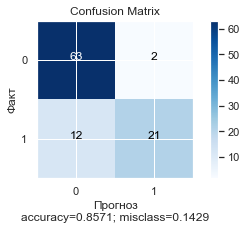

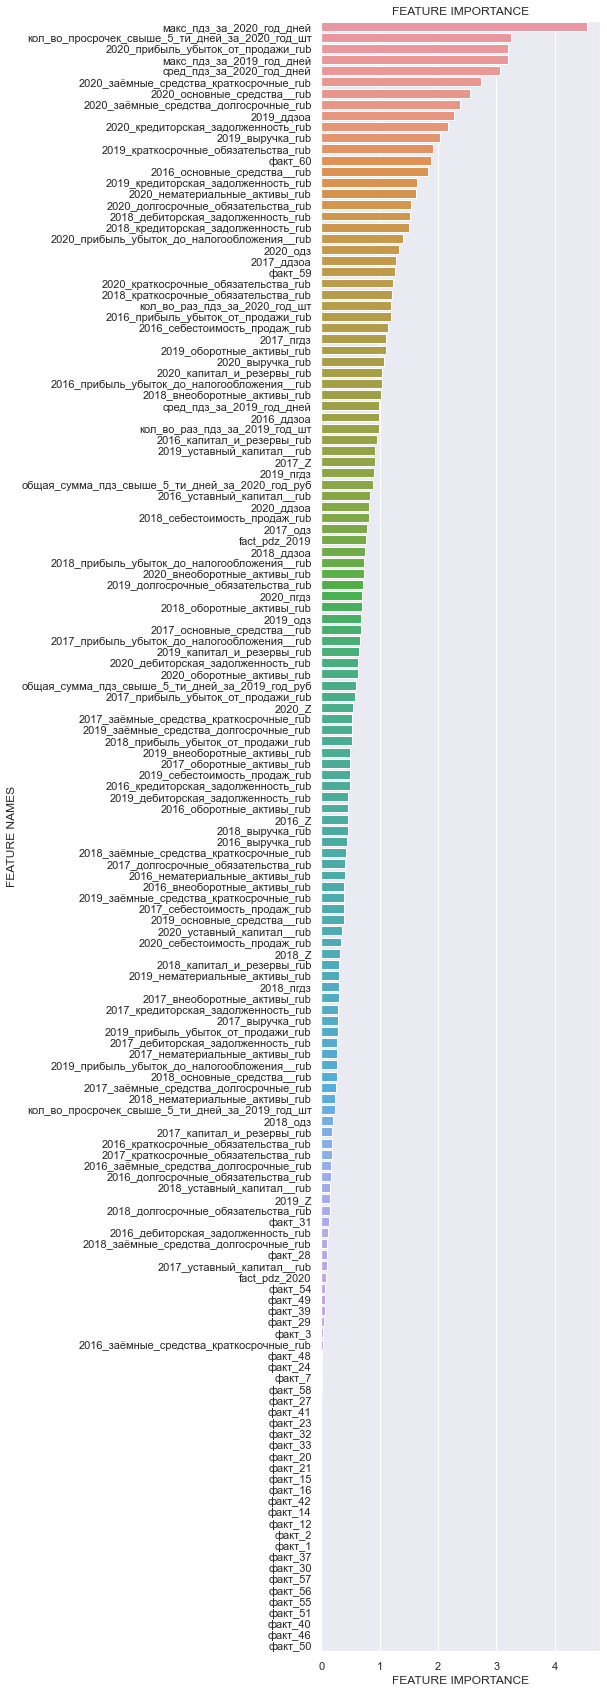

In [28]:
y_pred = model.predict(X_test)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print("f1: %.6f" % (f1))
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC_AUC: %f' % roc_auc)
print('Recall on train: %f' % recall_score(y_train, model.predict(X_train)))

# Cross validation scores
f1_scores = cross_val_score(cb_model, X_train, y_train, cv=5, scoring='f1',n_jobs=2)
print("f1 scores per fold : ",f1_scores," \nMean f1_scores= ",np.mean(f1_scores))

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

importance = cb_model.feature_importances_
res = plot_feature_importance(importance,X_train.columns,5,30)

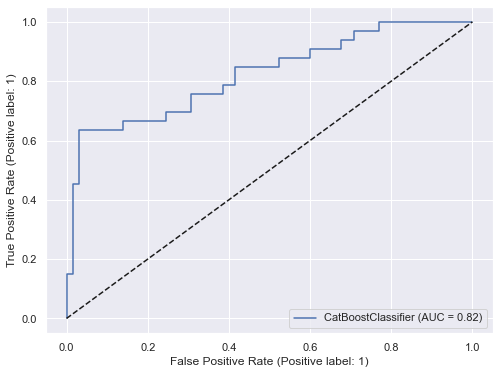

In [29]:
plot_roc_curve(model, X_test, y_test)
plt.plot([0,1], [0,1], '--', c='k')

### Вывод

**Из полученных выше результатов, можно выделить следующее:**  
**1) Большинство призанков Факт (от 1 до 60) не вносят какой-либо в клал в результат предсказания модели.**    
**2) Наиболее значимые факторы: Факт 60, Факт 59.**  
**3) В ТОП-10 признаков входят 6 признаков из предыдщуего года - то есть 2020 года. Таким образом в модели активно используются данные за предыдущий год.**

## Модель прогноза факта ПДЗ за весь период

### Подготовка данных для модели

In [30]:
df_by_years = pd.read_csv('df_by_years_total.csv')#.query('YY != 2019')

Формируем список cur_pdz_cols с колонками, содержащими информацию о ПДЗ для текущего года (для которого делаем прогноз)

In [31]:
cur_pdz_cols = []

for col_name in df_by_years.columns:
    if 'YY' not in col_name and col_name != 'fact_pdz':
        cur_pdz_cols.append(col_name)

Формируем колонку с таргетом (факт ПДЗ)

In [32]:
df_by_years['fact_pdz'] = df_by_years['кол_во_раз_пдз_за_год_шт'].apply(lambda x: 0 if x == 0 else 1)

Выбрасываем колонки cur_pdz

In [33]:
df_for_model = df_by_years.drop(columns=cur_pdz_cols)

print(df_for_model[df_for_model['fact_pdz']==0].shape, df_for_model[df_for_model['fact_pdz']==1].shape)

(516, 111) (1077, 111)


### Обучение модели

In [34]:
TARGET_NAME = 'fact_pdz'
y = df_for_model[TARGET_NAME]
X = df_for_model.drop(columns=[TARGET_NAME, 'YY'])   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle=True)

print(f"Кол-во записей в обучающей выборке: {X_train.shape}")
print(f"Кол-во записей в тестовой выборке: {X_test.shape}")

Кол-во записей в обучающей выборке: (1115, 109)
Кол-во записей в тестовой выборке: (478, 109)


In [35]:
numeric_features = list(X.columns)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'LGBMClassifier', 
         'Catboost']

classifiers = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier(), 
               LGBMClassifier(), CatBoostClassifier(thread_count=4)]
    
parameters = [{'classifier__max_depth': range (1, 50, 5), 'classifier__min_samples_leaf': range(1, 9, 2), 
              'classifier__min_samples_split': range(1, 7, 2), 'classifier__class_weight': ['balanced']}, 
              
              {'classifier__n_estimators': range (10, 20, 5), 'classifier__max_depth': range (1, 15, 3), 
               'classifier__min_samples_leaf': range(1, 3, 1), 'classifier__min_samples_split': range(1, 3, 1), 
               'classifier__class_weight': ['balanced']}, 
              
              {'classifier__solver': ['liblinear'], 'classifier__class_weight': ['balanced']},
              
              {'classifier__n_neighbors': range (1, 5, 1)},
              
              {'classifier__learning_rate': [0.1],'classifier__max_depth': range(10, 30, 5)},
              
              {'classifier__learning_rate': [0.2, 0.3], 'classifier__iterations': range(100, 200, 50), 'classifier__max_depth': range(1, 11, 3), 
              'classifier__logging_level' : ['Silent']}
              
             ]

In [36]:
def search_of_the_best_classifier(names, classifiers, parameters, X, y, X_hold_out, y_hold_out):
    """
    Function takes name of a model, a classifier, parameters of classifier and insert it to the GridSearch. Then the 
    function calculates predictions on the test df and draw a confusion matrix for each of a model.
    Entry parameters:
    names - list of the classifier's names
    classifiers - list of the classifiers
    parameters - list of the parametrs of the classifiers, located through a dictionary
    X - features train
    y - target test
    X_hold_out -features test 
    y_hold_out - taerget test
    
    Output parameters:
    result - dataframe with best models and best metrics
    predictions - list of predictions for each of the model
    model_fitted - list of fitted model
    """
    
    result = []
    model_fitted = []
    predictions = []

#Начинаем перебирать параметры через гридсечр    
    for name, classifier, hyperparam in zip(names, classifiers, parameters):
    
        clf = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
        model = GridSearchCV(clf, param_grid = hyperparam, cv=4, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
        auc_roc_valid = model.best_score_
    
        model_fitted.append(model)
        
#вычисяем предсказания и метрики
        predicted_test = model.best_estimator_.predict(X_hold_out)
        probabilities_test = model.best_estimator_.predict_proba(X_hold_out)
        probabilities_one_test = probabilities_test[:, 1]
        auc_roc = roc_auc_score(y_test, probabilities_one_test)
        accuracy = accuracy_score(y_hold_out, predicted_test)
        precision = precision_score(y_hold_out, predicted_test)
        recall = recall_score(y_hold_out, predicted_test)
        
#Сохраняем метрики и параметры лучших моделей в result    
        result.append([accuracy, precision, recall, auc_roc_valid, auc_roc, name, model.best_params_])
#Сохраняем предсказания в predictions
        predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                             'auc_roc на тесте', 'Название модели', 'Оптимальные параметры модель']) 

#Отрисовка confusion matrix
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    sns.heatmap(confusion_matrix(y_hold_out, predictions[0]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[0, 0]).set(title='DecisionTreeClassifier')
    axes[0, 0].set_ylabel('fact')
    axes[0, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[1]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[0, 1]).set(title='RandomForestClassifier')
    axes[0, 1].set_ylabel('fact')
    axes[0, 1].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[2]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[1, 0]).set(title='LogisticRegression')
    axes[1, 0].set_ylabel('fact')
    axes[1, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[3]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[1, 1]).set(title='KNeighborsClassifier')
    axes[1, 1].set_ylabel('fact')
    axes[1, 1].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[4]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[2, 0]).set(title='LGBMClassifier')
    axes[2, 0].set_ylabel('fact')
    axes[2, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[5]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[2, 1]).set(title='Catboost')
    axes[2, 1].set_ylabel('fact')
    axes[2, 1].set_xlabel('prediction')
    fig.suptitle('Матрицы ошибок')

    display(result.sort_values(by = 'auc_roc на тесте', ascending = False))
    return result, model_fitted, predictions

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Fitting 4 folds for each of 40 candidates, totalling 160 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits


,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Название модели,Оптимальные параметры модель
4,0.719665,0.775510,0.823529,0.815213,0.802227,LGBMClassifier,"{'classifier__learning_rate': 0.1, 'classifier..."
1,0.723849,0.819398,0.758514,0.810304,0.801648,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas..."
5,0.736402,0.790560,0.829721,0.812026,0.798092,Catboost,"{'classifier__iterations': 150, 'classifier__l..."
0,0.690377,0.802768,0.718266,0.755129,0.761160,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas..."
3,0.675732,0.728261,0.829721,0.649918,0.640917,KNeighborsClassifier,{'classifier__n_neighbors': 3}
2,0.564854,0.727273,0.569659,0.618714,0.590203,LogisticRegression,"{'classifier__class_weight': 'balanced', 'clas..."


Wall time: 6min 59s


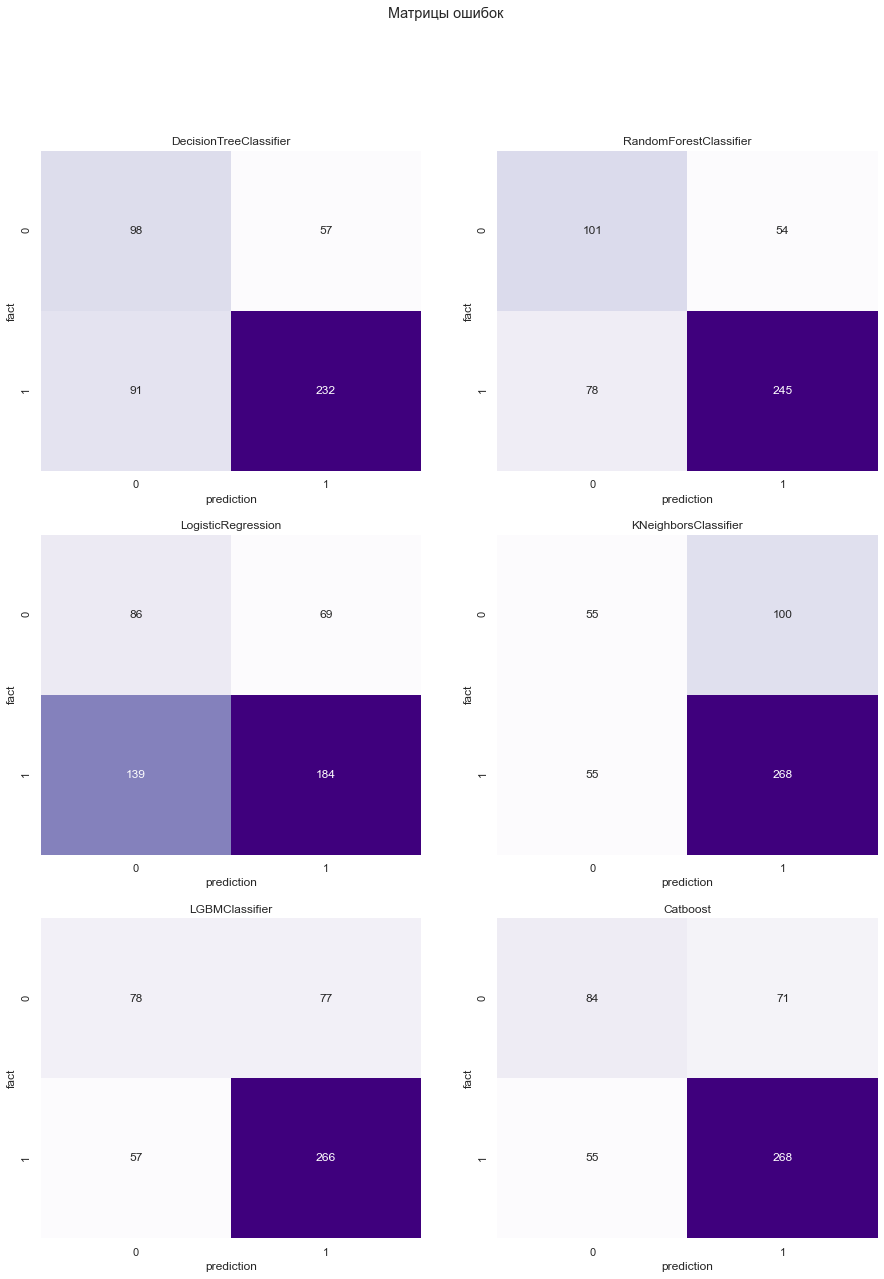

In [37]:
%%time
result, model_fitted, predictions = search_of_the_best_classifier(names, classifiers, parameters, X_train, y_train, X_test, y_test)

**Таким образом, мы определили 2 модели для baseline. Обе модели - это модели градиентного бустринга: LGBM Classifier, Catboost Classifier. В качестве метрики качетсва нужно использовать совокупность метрик: accuracy, precision, recall, roc_auc на тесте.**

### Feature importance для 2-х топовых моделей: LGBM и CatBoost

In [38]:
model_fitted[4].best_estimator_.named_steps['classifier']

LGBMClassifier(max_depth=10)

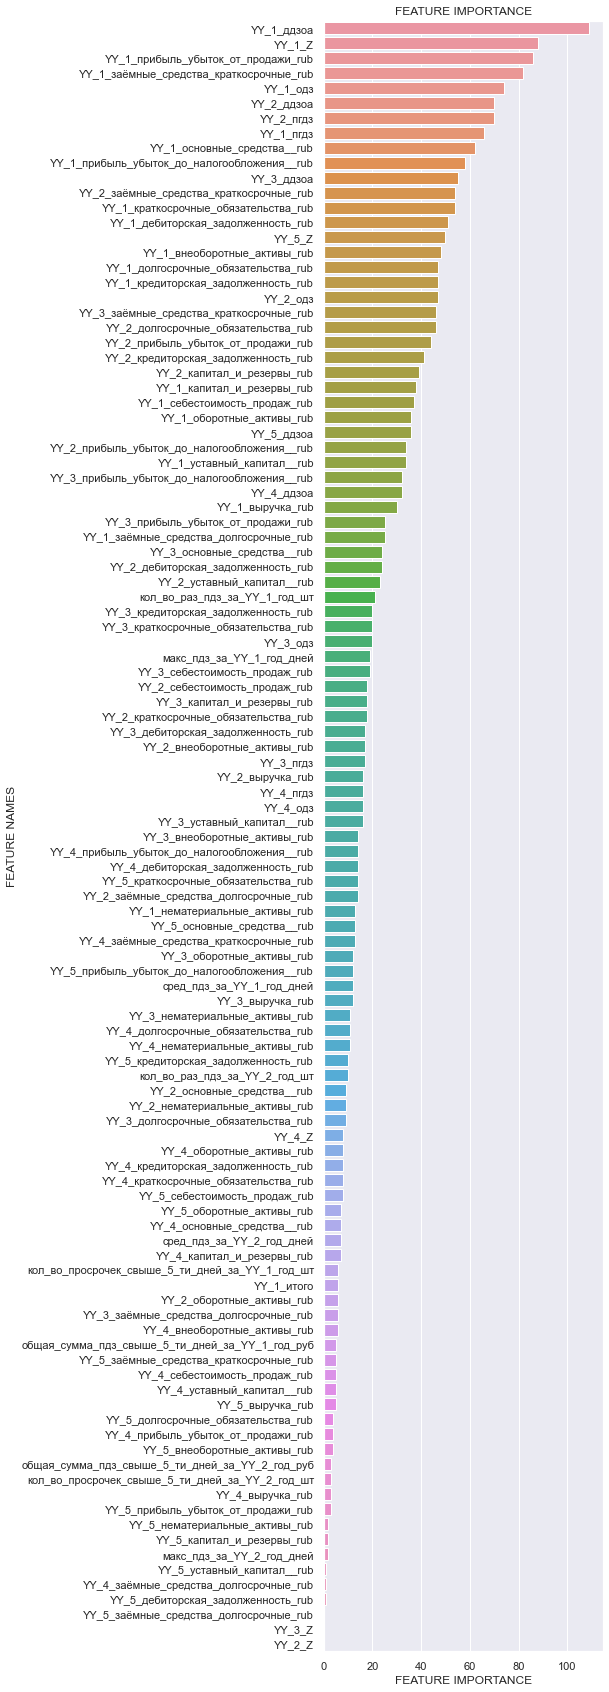

In [39]:
importance = model_fitted[4].best_estimator_.named_steps['classifier'].feature_importances_
lgbm_feature_imp = plot_feature_importance(importance,X_train.columns,5,30)

In [40]:
model_fitted[5].best_estimator_.named_steps['classifier']

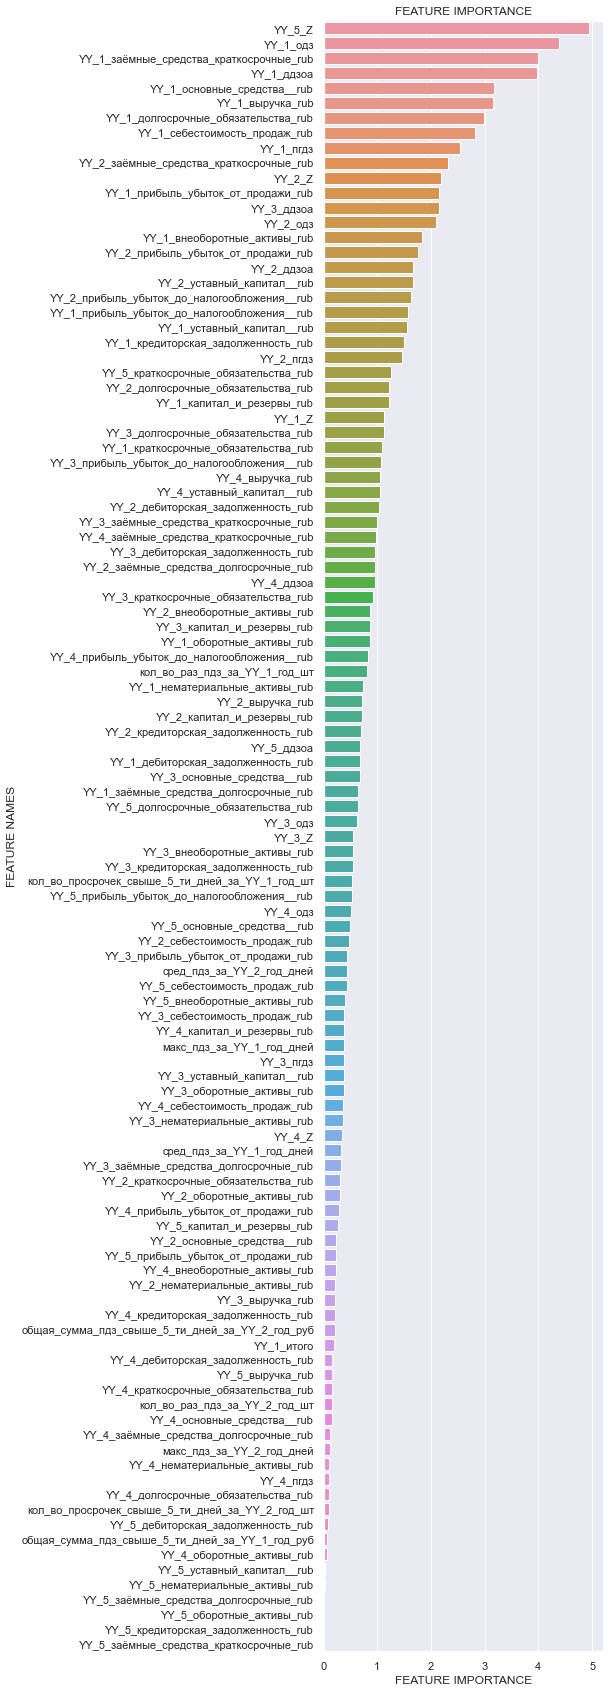

In [41]:
importance = model_fitted[5].best_estimator_.named_steps['classifier'].feature_importances_
catboost_feature_imp = plot_feature_importance(importance,X_train.columns,5,30)

**Для LGBM Classifier в ТОП-10 входит большое количество сгенерированных фитчей (5 из ТОП-10 сгенерированные фитчи).**  
**Для Catboost Classifier в ТОП-10 входят 2 сгенерированные фитчи.**

### Исследование качества модели LGBM в зависимости от набора фичей

In [42]:
TARGET_NAME = 'fact_pdz'
y = df_for_model[TARGET_NAME]
X = df_for_model.drop(columns=[TARGET_NAME, 'YY'])   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle=True)

print(f"Кол-во записей в обучающей выборке: {X_train.shape}")
print(f"Кол-во записей в тестовой выборке: {X_test.shape}")

Кол-во записей в обучающей выборке: (1115, 109)
Кол-во записей в тестовой выборке: (478, 109)


**Проведем следующую операцию: из всех наших фитчей будем отбирать фитчи согласно feature_importance и далее обучать модель на них.**

**Начнем с ТОП-5 фмтчей и далье пойдем с шагом в 10 фитчей, пока не покроем все фитчи**

In [43]:
%%time
final_result = pd.DataFrame()
for amount in range(5, 116, 10):
    X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(amount, X_train, X_test, lgbm_feature_imp)

    
    result = []
    model_fitted = []
    predictions = []
    amount_result = []

    model = LGBMClassifier()
    parameters = {'learning_rate': [0.1],'max_depth': range(10, 30, 5)}
  
    grid = GridSearchCV(model, param_grid = parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
    model = grid.fit(X_train_new, y_train)

    auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
    model_fitted.append(model)

    #вычисяем предсказания и метрики
    predicted_test = model.best_estimator_.predict(X_test_new)
    probabilities_test = model.best_estimator_.predict_proba(X_test_new)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one_test)
    accuracy = accuracy_score(y_test, predicted_test)
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    amount_result.append(amount)

    #Сохраняем метрики и параметры лучших моделей в result    
    result.append([amount, accuracy, precision, recall, auc_roc_valid, auc_roc, model.best_params_])
    #Сохраняем предсказания в predictions
    predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['Кол-во топ фитчей', 'accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                                 'auc_roc на тесте', 'Оптимальные параметры модель']) 
    
    final_result = pd.concat([final_result, result], axis = 0)
    final_result_lgbm = final_result
    
    #Отрисовка confusion matrix

display(final_result_lgbm)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


,Кол-во топ фитчей,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Оптимальные параметры модель
0,5,0.635983,0.729231,0.733746,0.728450,0.702607,"{'learning_rate': 0.1, 'max_depth': 15}"
0,15,0.702929,0.780186,0.780186,0.810271,0.764386,"{'learning_rate': 0.1, 'max_depth': 10}"
0,25,0.738494,0.803681,0.811146,0.815258,0.792350,"{'learning_rate': 0.1, 'max_depth': 15}"
0,35,0.734310,0.786550,0.832817,0.817206,0.795266,"{'learning_rate': 0.1, 'max_depth': 10}"
0,45,0.738494,0.798193,0.820433,0.819969,0.806112,"{'learning_rate': 0.1, 'max_depth': 15}"
0,55,0.723849,0.786787,0.811146,0.812951,0.797973,"{'learning_rate': 0.1, 'max_depth': 10}"
0,65,0.732218,0.794562,0.814241,0.807299,0.815590,"{'learning_rate': 0.1, 'max_depth': 15}"
0,75,0.734310,0.791667,0.823529,0.805578,0.809578,"{'learning_rate': 0.1, 'max_depth': 10}"
0,85,0.728033,0.789790,0.814241,0.805485,0.804944,"{'learning_rate': 0.1, 'max_depth': 10}"
0,95,0.734310,0.783237,0.839009,0.805565,0.808159,"{'learning_rate': 0.1, 'max_depth': 20}"


Wall time: 17.6 s


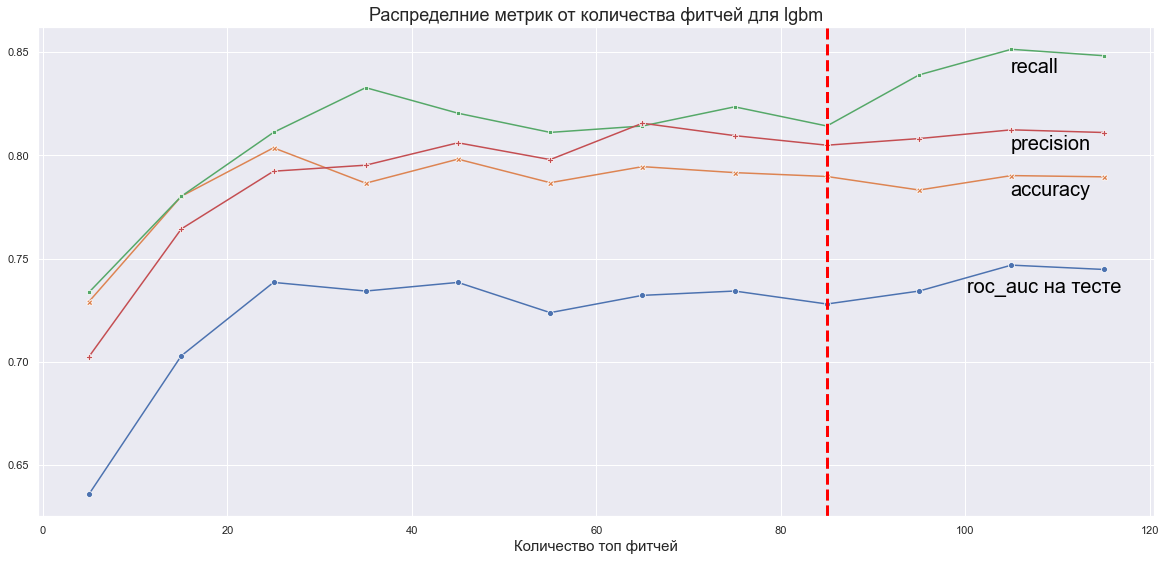

In [44]:
sns.set()
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределние метрик от количества фитчей для lgbm', fontsize=18)
axes.set_xlabel('Количество топ фитчей', fontsize=15)
sns.lineplot(data=final_result_lgbm.set_index('Кол-во топ фитчей')[['accuracy', 'precision', 'recall', 'auc_roc на тесте']], markers=True, dashes=False, legend = False)
#axes.legend(labels=["accuracy","precision", "recall","roc_auc на тесте"], fontsize=15);
f.text(0.8, 0.81, 'recall', fontsize=20,  color='black')
f.text(0.8, 0.69, 'precision', fontsize=20,  color='black')
f.text(0.8, 0.62, 'accuracy', fontsize=20,  color='black')
f.text(0.77, 0.47, 'roc_auc на тесте', fontsize=20,  color='black')
plt.axvline(85, 0, color = 'red', linestyle='--', linewidth = 3);

**Для модели LGBM, постепенный выход на плато происходит начиная с то 55 фитчей, но лучший рузультат по метрикам смотрится начиная с 85 фитчей.**

### Исследование качества модели CatBoost в зависимости от набора фичей

In [45]:
%%time
final_result = pd.DataFrame()
for amount in range(5, 116, 10):
    X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(amount, X_train, X_test, catboost_feature_imp)
 
    result = []
    model_fitted = []
    predictions = []
    amount_result = []

    model = CatBoostClassifier(thread_count=4)
    parameters = {'learning_rate': [0.2, 0.3], 'iterations': range(100, 200, 50), 'logging_level' : ['Silent'], 
                  'max_depth': range(1, 11, 3)}
    
    
  
    grid = GridSearchCV(model, param_grid = parameters, cv = 4, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
    model = grid.fit(X_train_new, y_train)

    auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
    model_fitted.append(model)

    #вычисяем предсказания и метрики
    predicted_test = model.best_estimator_.predict(X_test_new)
    probabilities_test = model.best_estimator_.predict_proba(X_test_new)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one_test)
    accuracy = accuracy_score(y_test, predicted_test)
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    amount_result.append(amount)

    #Сохраняем метрики и параметры лучших моделей в result    
    result.append([amount, accuracy, precision, recall, auc_roc_valid, auc_roc, model.best_params_])
    #Сохраняем предсказания в predictions
    predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['Кол-во топ фитчей', 'accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                                 'auc_roc на тесте', 'Оптимальные параметры модель']) 
    
    final_result = pd.concat([final_result, result], axis = 0)
    
    #Отрисовка confusion matrix

display(final_result)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits


,Кол-во топ фитчей,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Оптимальные параметры модель
0,5,0.698745,0.760933,0.808050,0.817944,0.774903,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,15,0.707113,0.773134,0.801858,0.817335,0.772356,"{'iterations': 150, 'learning_rate': 0.2, 'log..."
0,25,0.753138,0.798834,0.848297,0.814904,0.796584,"{'iterations': 150, 'learning_rate': 0.2, 'log..."
0,35,0.711297,0.766571,0.823529,0.817432,0.774753,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,45,0.717573,0.768571,0.832817,0.812134,0.793079,"{'iterations': 150, 'learning_rate': 0.2, 'log..."
0,55,0.742678,0.795858,0.832817,0.810541,0.797393,"{'iterations': 150, 'learning_rate': 0.3, 'log..."
0,65,0.728033,0.788060,0.817337,0.811149,0.807301,"{'iterations': 150, 'learning_rate': 0.3, 'log..."
0,75,0.715481,0.774194,0.817337,0.816689,0.799431,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,85,0.738494,0.789474,0.835913,0.813341,0.815210,"{'iterations': 150, 'learning_rate': 0.2, 'log..."
0,95,0.728033,0.778098,0.835913,0.809457,0.806901,"{'iterations': 150, 'learning_rate': 0.2, 'log..."


Wall time: 44min 12s


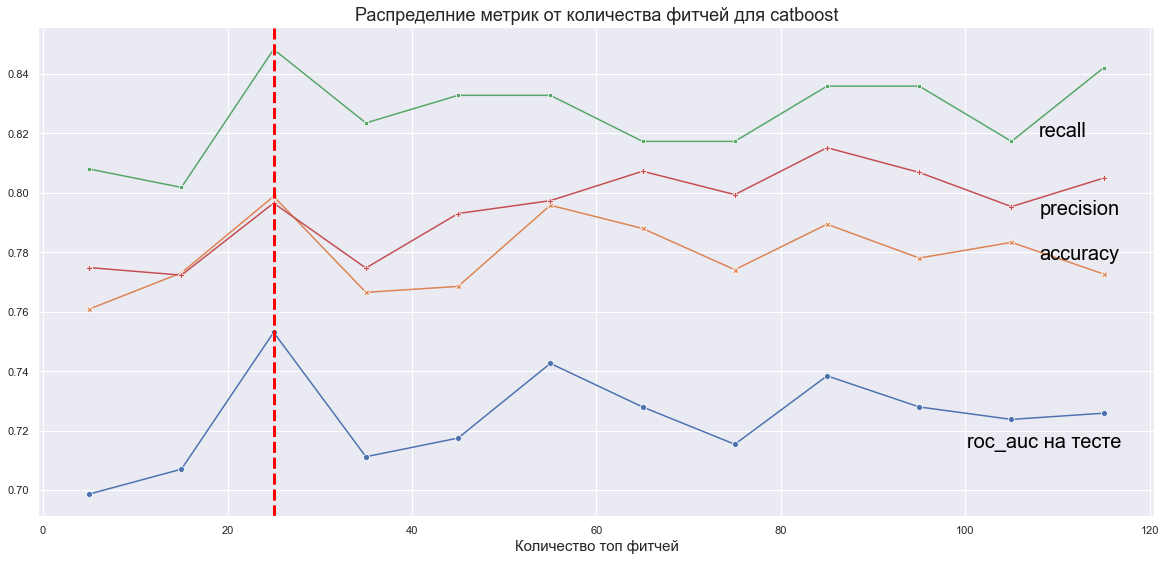

In [46]:
sns.set()
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределние метрик от количества фитчей для catboost', fontsize=18)
axes.set_xlabel('Количество топ фитчей', fontsize=15)
sns.lineplot(data=final_result.set_index('Кол-во топ фитчей')[['accuracy', 'precision', 'recall', 'auc_roc на тесте']], markers=True, dashes=False, legend = False)
#axes.legend(labels=["accuracy","precision", "recall","roc_auc на тесте"], fontsize=15);
f.text(0.82, 0.71, 'recall', fontsize=20,  color='black')
f.text(0.82, 0.59, 'precision', fontsize=20,  color='black')
f.text(0.82, 0.52, 'accuracy', fontsize=20,  color='black')
f.text(0.77, 0.23, 'roc_auc на тесте', fontsize=20,  color='black')
plt.axvline(25, 0, color = 'red', linestyle='--', linewidth = 3);

In [47]:
%%time
final_result = pd.DataFrame()

X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(25, X_train, X_test, catboost_feature_imp)
 
result = []
model_fitted = []
predictions = []
amount_result = []

model = CatBoostClassifier(thread_count=4)
parameters = {'learning_rate': [0.2, 0.3], 'iterations': range(100, 200, 50), 'logging_level' : ['Silent'], 
                  'max_depth': range(1, 11, 3)}
    
    
  
grid = GridSearchCV(model, param_grid = parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
model = grid.fit(X_train_new, y_train)

auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
model_fitted.append(model)

    #вычисяем предсказания и метрики
predicted_test = model.best_estimator_.predict(X_test_new)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Wall time: 1min 17s


[[ 82  73]
 [ 60 263]]


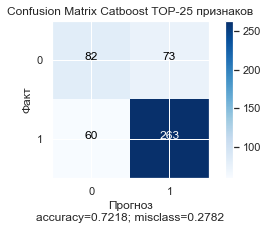

In [48]:
cm = confusion_matrix(np.array(y_test), predicted_test)
print(cm)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix Catboost TOP-25 признаков")

#importance = cb_model.feature_importances_
#res = plot_feature_importance(importance,X_train.columns,5,30)

**Для модели Catboost на ТОП-25 фитчах наблюдается выход на плато по метрикам. В данном случае, есть возможность использовать первые ТОП-15 фитчей, что значительно ускорит вычисления, но не ухудшит метрки.**

## Модель прогноза факта ПДЗ за весь период для новых контрагентов

### Подготовка данных для модели

In [49]:
df_by_years = pd.read_csv('df_by_years_total.csv')#.query('YY != 2019')

df_by_years

,YY,YY_1_Z,YY_1_внеоборотные_активы_rub,YY_1_выручка_rub,YY_1_ддзоа,YY_1_дебиторская_задолженность_rub,YY_1_долгосрочные_обязательства_rub,YY_1_заёмные_средства_долгосрочные_rub,YY_1_заёмные_средства_краткосрочные_rub,YY_1_итого,YY_1_капитал_и_резервы_rub,YY_1_краткосрочные_обязательства_rub,YY_1_кредиторская_задолженность_rub,YY_1_нематериальные_активы_rub,YY_1_оборотные_активы_rub,YY_1_одз,YY_1_основные_средства__rub,YY_1_пгдз,YY_1_прибыль_убыток_до_налогообложения__rub,YY_1_прибыль_убыток_от_продажи_rub,YY_1_себестоимость_продаж_rub,YY_1_уставный_капитал__rub,YY_2_Z,YY_2_внеоборотные_активы_rub,YY_2_выручка_rub,YY_2_ддзоа,YY_2_дебиторская_задолженность_rub,YY_2_долгосрочные_обязательства_rub,YY_2_заёмные_средства_долгосрочные_rub,YY_2_заёмные_средства_краткосрочные_rub,YY_2_капитал_и_резервы_rub,YY_2_краткосрочные_обязательства_rub,YY_2_кредиторская_задолженность_rub,YY_2_нематериальные_активы_rub,YY_2_оборотные_активы_rub,YY_2_одз,YY_2_основные_средства__rub,YY_2_пгдз,YY_2_прибыль_убыток_до_налогообложения__rub,YY_2_прибыль_убыток_от_продажи_rub,YY_2_себестоимость_продаж_rub,YY_2_уставный_капитал__rub,YY_3_Z,YY_3_внеоборотные_активы_rub,YY_3_выручка_rub,YY_3_ддзоа,YY_3_дебиторская_задолженность_rub,YY_3_долгосрочные_обязательства_rub,YY_3_заёмные_средства_долгосрочные_rub,YY_3_заёмные_средства_краткосрочные_rub,YY_3_капитал_и_резервы_rub,YY_3_краткосрочные_обязательства_rub,YY_3_кредиторская_задолженность_rub,YY_3_нематериальные_активы_rub,YY_3_оборотные_активы_rub,YY_3_одз,YY_3_основные_средства__rub,YY_3_пгдз,YY_3_прибыль_убыток_до_налогообложения__rub,YY_3_прибыль_убыток_от_продажи_rub,YY_3_себестоимость_продаж_rub,YY_3_уставный_капитал__rub,YY_4_Z,YY_4_внеоборотные_активы_rub,YY_4_выручка_rub,YY_4_ддзоа,YY_4_дебиторская_задолженность_rub,YY_4_долгосрочные_обязательства_rub,YY_4_заёмные_средства_долгосрочные_rub,YY_4_заёмные_средства_краткосрочные_rub,YY_4_капитал_и_резервы_rub,YY_4_краткосрочные_обязательства_rub,YY_4_кредиторская_задолженность_rub,YY_4_нематериальные_активы_rub,YY_4_оборотные_активы_rub,YY_4_одз,YY_4_основные_средства__rub,YY_4_пгдз,YY_4_прибыль_убыток_до_налогообложения__rub,YY_4_прибыль_убыток_от_продажи_rub,YY_4_себестоимость_продаж_rub,YY_4_уставный_капитал__rub,YY_5_Z,YY_5_внеоборотные_активы_rub,YY_5_выручка_rub,YY_5_ддзоа,YY_5_дебиторская_задолженность_rub,YY_5_долгосрочные_обязательства_rub,YY_5_заёмные_средства_долгосрочные_rub,YY_5_заёмные_средства_краткосрочные_rub,YY_5_капитал_и_резервы_rub,YY_5_краткосрочные_обязательства_rub,YY_5_кредиторская_задолженность_rub,YY_5_нематериальные_активы_rub,YY_5_оборотные_активы_rub,YY_5_основные_средства__rub,YY_5_прибыль_убыток_до_налогообложения__rub,YY_5_прибыль_убыток_от_продажи_rub,YY_5_себестоимость_продаж_rub,YY_5_уставный_капитал__rub,Z,внеоборотные_активы_rub,выручка_rub,ддзоа,дебиторская_задолженность_rub,долгосрочные_обязательства_rub,заёмные_средства_долгосрочные_rub,заёмные_средства_краткосрочные_rub,итого,капитал_и_резервы_rub,кол_во_просрочек_свыше_5_ти_дней_за_YY_1_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_YY_2_год_шт,кол_во_просрочек_свыше_5_ти_дней_за_год_шт,кол_во_раз_пдз_за_YY_1_год_шт,кол_во_раз_пдз_за_YY_2_год_шт,кол_во_раз_пдз_за_год_шт,краткосрочные_обязательства_rub,кредиторская_задолженность_rub,макс_пдз_за_YY_1_год_дней,макс_пдз_за_YY_2_год_дней,макс_пдз_за_год_дней,наименование_дп,нематериальные_активы_rub,оборотные_активы_rub,общая_сумма_пдз_свыше_5_ти_дней_за_YY_1_год_руб,общая_сумма_пдз_свыше_5_ти_дней_за_YY_2_год_руб,общая_сумма_пдз_свыше_5_ти_дней_за_год_руб,одз,основные_средства__rub,оценка_потенциала_контрагента_1_руб,оценка_потенциала_контрагента_2_руб,пгдз,пдз_1_30,пдз_31_90,пдз_91_365,пдз_более_365,прибыль_убыток_до_налогообложения__rub,прибыль_убыток_от_продажи_rub,себестоимость_продаж_rub,сред_пдз_за_YY_1_год_дней,сред_пдз_за_YY_2_год_дней,сред_пдз_за_год_дней,уставный_капитал__rub
0,2021,2.886633,4.379874e+09,2.794788e+10,0.806640,4.977055e+09,2.174739e+08,0.000000e+00,0.000000e+00,10.0,6.881321e+09,3.451186e+09

In [50]:
pdz_cols = ['YY_3', 'YY_4', 'YY_5', 'ддзоа', 'одз', 'пгдз', 'дебиторская_задолженность', 'итого', 'кол_во_просрочек', 'кол_во_раз_пдз', 'макс_пдз', 'общая_сумма_пдз', 'сред_пдз']

Формируем список cur_pdz_cols с колонками, содержащими информацию о ПДЗ для текущего года (для которого делаем прогноз)

In [51]:
cur_pdz_cols = []

for col_name in df_by_years.columns:
    if 'YY' not in col_name and col_name != 'fact_pdz':
        cur_pdz_cols.append(col_name)
    for pdz_col_name in pdz_cols:
        if pdz_col_name in col_name and col_name not in cur_pdz_cols:
            cur_pdz_cols.append(col_name)

Формируем колонку с таргетом (факт ПДЗ)

In [52]:
df_by_years['fact_pdz'] = df_by_years['кол_во_раз_пдз_за_год_шт'].apply(lambda x: 0 if x == 0 else 1)

Выбрасываем колонки cur_pdz

In [53]:
df_for_model = df_by_years.drop(columns=cur_pdz_cols)

print(df_for_model[df_for_model['fact_pdz']==0].shape, df_for_model[df_for_model['fact_pdz']==1].shape)

(516, 34) (1077, 34)


### Обучение модели

In [54]:
TARGET_NAME = 'fact_pdz'
y = df_for_model[TARGET_NAME]
X = df_for_model.drop(columns=[TARGET_NAME, 'YY'])   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle=True)

print(f"Кол-во записей в обучающей выборке: {X_train.shape}")
print(f"Кол-во записей в тестовой выборке: {X_test.shape}")

Кол-во записей в обучающей выборке: (1115, 32)
Кол-во записей в тестовой выборке: (478, 32)


In [55]:
numeric_features = list(X.columns)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'LGBMClassifier', 
         'Catboost']

classifiers = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier(), 
               LGBMClassifier(), CatBoostClassifier(thread_count=4)]
    
parameters = [{'classifier__max_depth': range (1, 50, 5), 'classifier__min_samples_leaf': range(1, 9, 1), 
              'classifier__min_samples_split': range(1, 7, 1), 'classifier__class_weight': ['balanced']}, 
              
              {'classifier__n_estimators': range (10, 20, 5), 'classifier__max_depth': range (1, 15, 3), 
               'classifier__min_samples_leaf': range(1, 3, 1), 'classifier__min_samples_split': range(1, 3, 1), 
               'classifier__class_weight': ['balanced']}, 
              
              {'classifier__solver': ['liblinear'], 'classifier__class_weight': ['balanced']},
              
              {'classifier__n_neighbors': range (1, 5, 1)},
              
              {'classifier__learning_rate': [0.1],'classifier__max_depth': range(10, 30, 5)},
              
              {'classifier__learning_rate': [0.2, 0.3], 'classifier__iterations': range(100, 200, 50), 'classifier__max_depth': range(1, 11, 3), 
              'classifier__logging_level' : ['Silent']}
              
             ]

In [56]:
def search_of_the_best_classifier(names, classifiers, parameters, X, y, X_hold_out, y_hold_out):
    """
    Function takes name of a model, a classifier, parameters of classifier and insert it to the GridSearch. Then the 
    function calculates predictions on the test df and draw a confusion matrix for each of a model.
    Entry parameters:
    names - list of the classifier's names
    classifiers - list of the classifiers
    parameters - list of the parametrs of the classifiers, located through a dictionary
    X - features train
    y - target test
    X_hold_out -features test 
    y_hold_out - taerget test
    
    Output parameters:
    result - dataframe with best models and best metrics
    predictions - list of predictions for each of the model
    model_fitted - list of fitted model
    """
    
    result = []
    model_fitted = []
    predictions = []

#Начинаем перебирать параметры через гридсечр    
    for name, classifier, hyperparam in zip(names, classifiers, parameters):
    
        clf = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
        model = GridSearchCV(clf, param_grid = hyperparam, cv=4, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
        auc_roc_valid = model.best_score_
    
        model_fitted.append(model)
        
#вычисяем предсказания и метрики
        predicted_test = model.best_estimator_.predict(X_hold_out)
        probabilities_test = model.best_estimator_.predict_proba(X_hold_out)
        probabilities_one_test = probabilities_test[:, 1]
        auc_roc = roc_auc_score(y_test, probabilities_one_test)
        accuracy = accuracy_score(y_hold_out, predicted_test)
        precision = precision_score(y_hold_out, predicted_test)
        recall = recall_score(y_hold_out, predicted_test)
        
#Сохраняем метрики и параметры лучших моделей в result    
        result.append([accuracy, precision, recall, auc_roc_valid, auc_roc, name, model.best_params_])
#Сохраняем предсказания в predictions
        predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                             'auc_roc на тесте', 'Название модели', 'Оптимальные параметры модель']) 
    
#Отрисовка confusion matrix
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    sns.heatmap(confusion_matrix(y_hold_out, predictions[0]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[0, 0]).set(title='DecisionTreeClassifier')
    axes[0, 0].set_ylabel('fact')
    axes[0, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[1]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[0, 1]).set(title='RandomForestClassifier')
    axes[0, 1].set_ylabel('fact')
    axes[0, 1].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[2]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[1, 0]).set(title='LogisticRegression')
    axes[1, 0].set_ylabel('fact')
    axes[1, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[3]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[1, 1]).set(title='KNeighborsClassifier')
    axes[1, 1].set_ylabel('fact')
    axes[1, 1].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[4]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[2, 0]).set(title='LGBMClassifier')
    axes[2, 0].set_ylabel('fact')
    axes[2, 0].set_xlabel('prediction')
    sns.heatmap(confusion_matrix(y_hold_out, predictions[5]), annot=True, fmt='d',cmap="Purples",cbar=False,
                ax = axes[2, 1]).set(title='Catboost')
    axes[2, 1].set_ylabel('fact')
    axes[2, 1].set_xlabel('prediction')
    fig.suptitle('Матрицы ошибок')

    
    display(result.sort_values(by = 'auc_roc на тесте', ascending = False))
    return result, model_fitted, predictions

Fitting 4 folds for each of 480 candidates, totalling 1920 fits
Fitting 4 folds for each of 40 candidates, totalling 160 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits


,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Название модели,Оптимальные параметры модель
4,0.661088,0.743202,0.761610,0.709669,0.726116,LGBMClassifier,"{'classifier__learning_rate': 0.1, 'classifier..."
5,0.658996,0.723464,0.801858,0.717290,0.719964,Catboost,"{'classifier__iterations': 100, 'classifier__l..."
1,0.608787,0.882022,0.486068,0.731450,0.711515,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas..."
0,0.631799,0.777358,0.637771,0.712313,0.697833,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas..."
3,0.640167,0.778598,0.653251,0.682420,0.678298,KNeighborsClassifier,{'classifier__n_neighbors': 4}
2,0.376569,0.666667,0.154799,0.506143,0.442685,LogisticRegression,"{'classifier__class_weight': 'balanced', 'clas..."


Wall time: 2min 21s


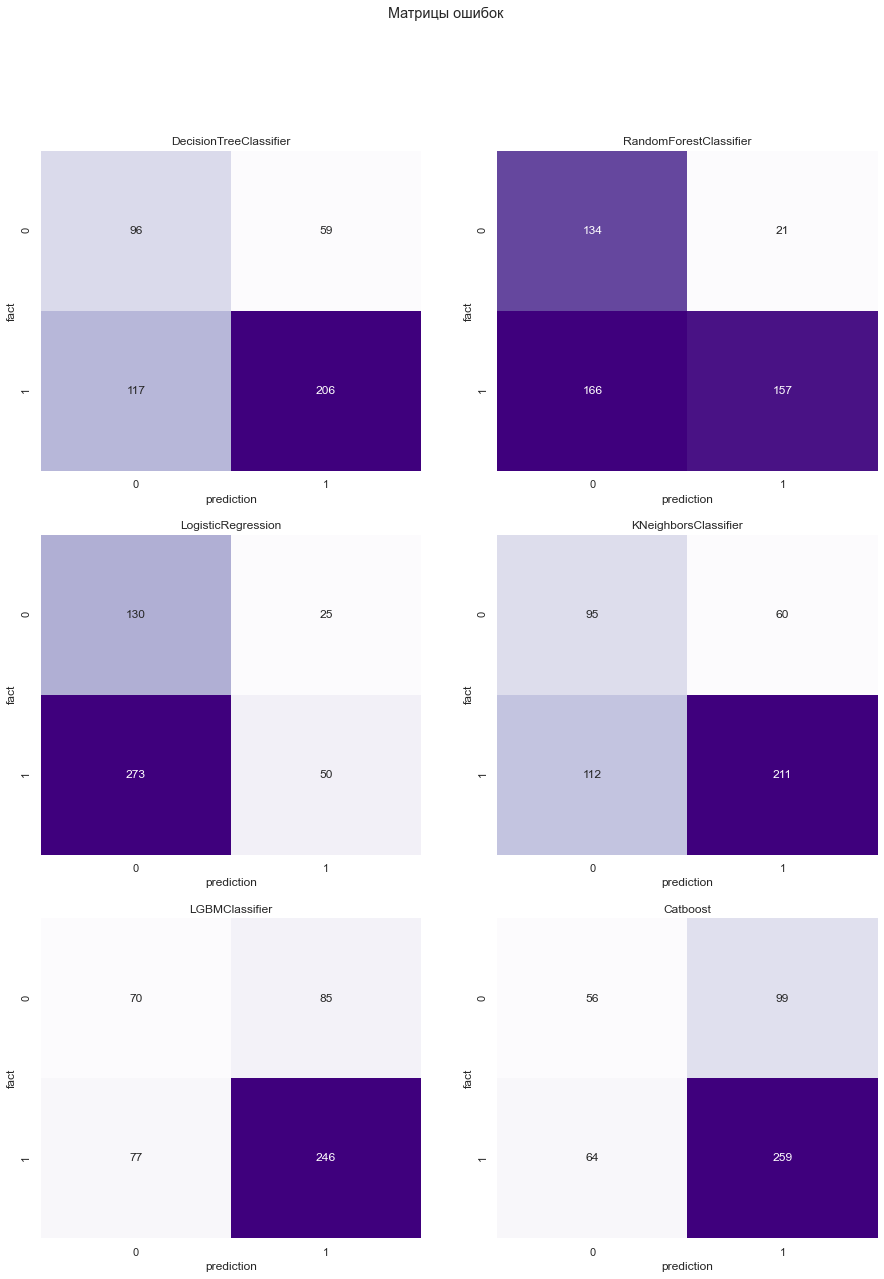

In [57]:
%%time
result, model_fitted, predictions = search_of_the_best_classifier(names, classifiers, parameters, X_train, y_train, X_test, y_test)

### Feature importance для 2-х топовых моделей: LGBM и CatBoost

In [58]:
model_fitted[4].best_estimator_.named_steps['classifier']

LGBMClassifier(max_depth=10)

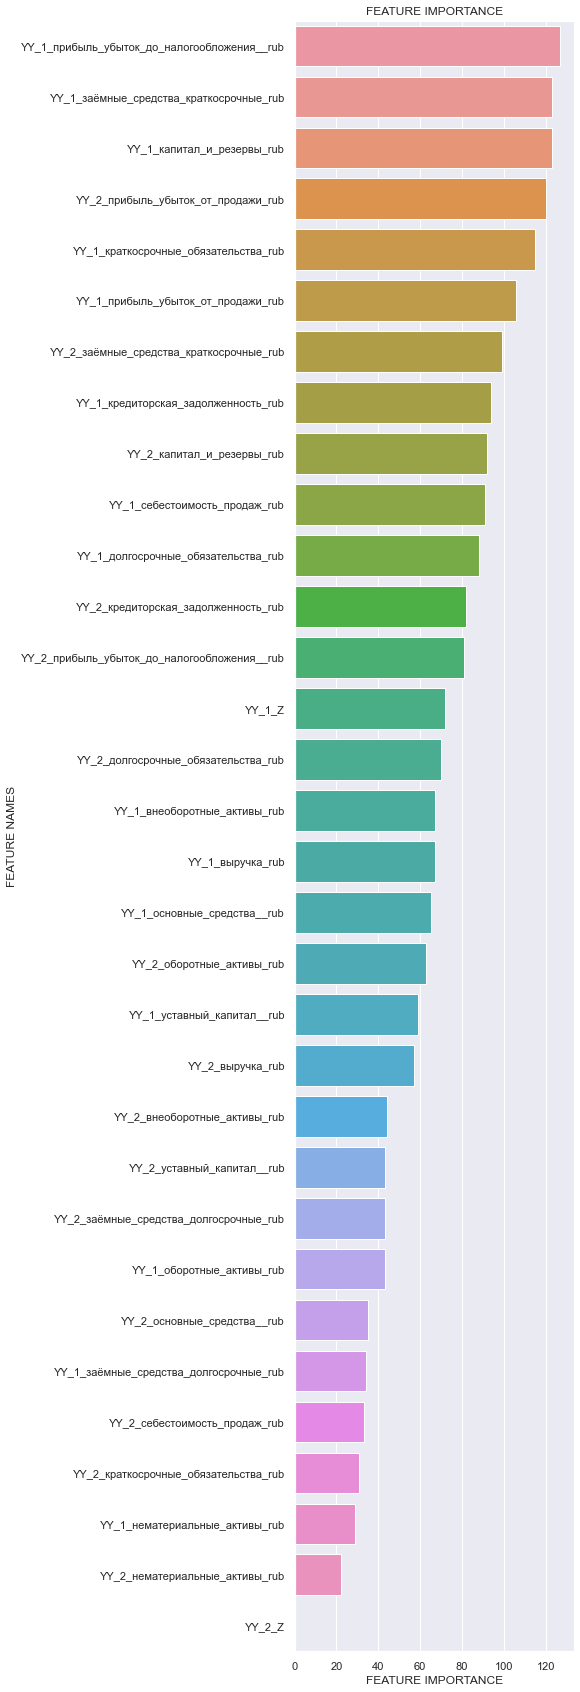

In [59]:
importance = model_fitted[4].best_estimator_.named_steps['classifier'].feature_importances_
lgbm_feature_imp = plot_feature_importance(importance,X_train.columns,5,30)

In [60]:
model_fitted[5].best_estimator_.named_steps['classifier']

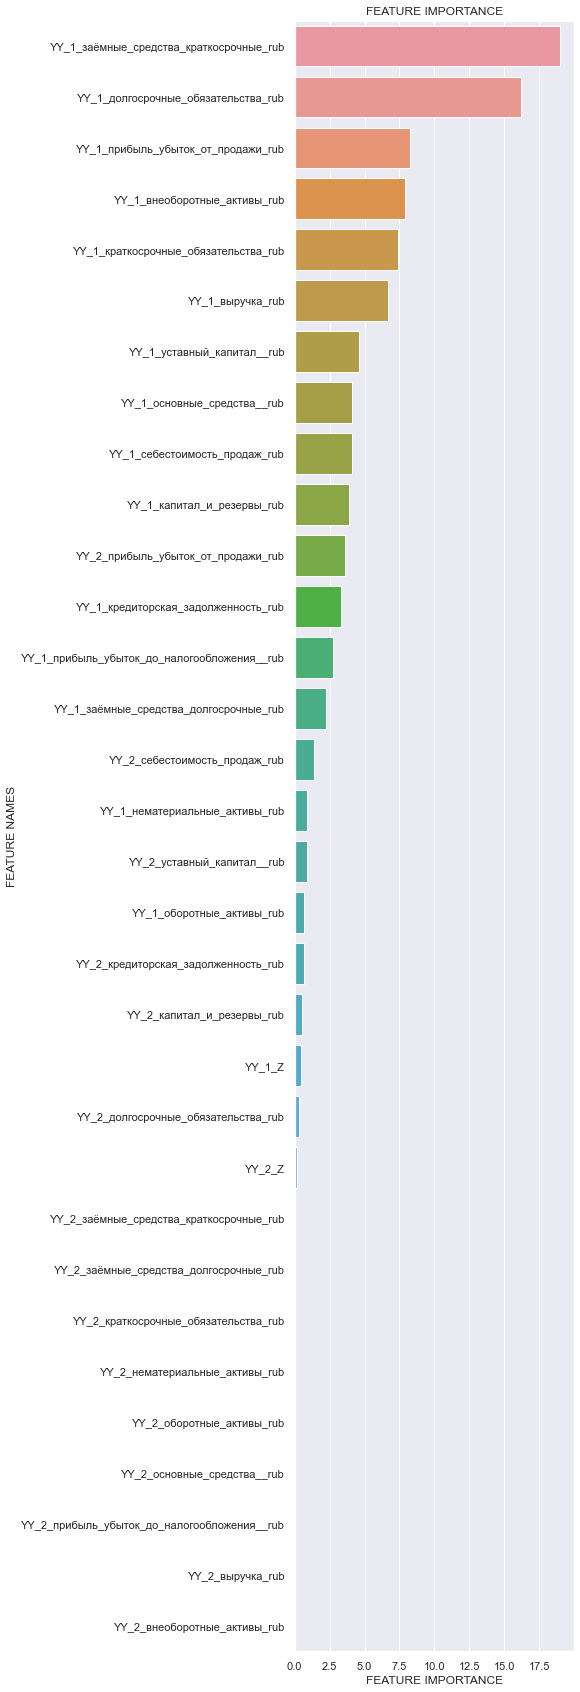

In [61]:
importance = model_fitted[5].best_estimator_.named_steps['classifier'].feature_importances_
catboost_feature_imp = plot_feature_importance(importance,X_train.columns,5,30)

### Исследование качества модели LGBM в зависимости от набора фичей

In [62]:
%%time
final_result = pd.DataFrame()
for amount in range(5, 33, 3):
    X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(amount, X_train, X_test, lgbm_feature_imp)

    
    result = []
    model_fitted = []
    predictions = []
    amount_result = []

    model = LGBMClassifier()
    parameters = {'learning_rate': [0.1],'max_depth': range(10, 30, 5)}
  
    grid = GridSearchCV(model, param_grid = parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
    model = grid.fit(X_train_new, y_train)

    auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
    model_fitted.append(model)

    #вычисяем предсказания и метрики
    predicted_test = model.best_estimator_.predict(X_test_new)
    probabilities_test = model.best_estimator_.predict_proba(X_test_new)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one_test)
    accuracy = accuracy_score(y_test, predicted_test)
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    amount_result.append(amount)

    #Сохраняем метрики и параметры лучших моделей в result    
    result.append([amount, accuracy, precision, recall, auc_roc_valid, auc_roc, model.best_params_])
    #Сохраняем предсказания в predictions
    predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['Кол-во топ фитчей', 'accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                                 'auc_roc на тесте', 'Оптимальные параметры модель']) 
    
    final_result = pd.concat([final_result, result], axis = 0)
    final_result_lgbm = final_result
    
    #Отрисовка confusion matrix

display(final_result_lgbm)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


,Кол-во топ фитчей,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Оптимальные параметры модель
0,5,0.640167,0.738170,0.724458,0.751996,0.706492,"{'learning_rate': 0.1, 'max_depth': 10}"
0,8,0.648536,0.746032,0.727554,0.751498,0.716319,"{'learning_rate': 0.1, 'max_depth': 10}"
0,11,0.661088,0.749226,0.749226,0.737003,0.739748,"{'learning_rate': 0.1, 'max_depth': 25}"
0,14,0.665272,0.749235,0.758514,0.739138,0.735504,"{'learning_rate': 0.1, 'max_depth': 10}"
0,17,0.671548,0.739884,0.792570,0.733261,0.735684,"{'learning_rate': 0.1, 'max_depth': 10}"
0,20,0.658996,0.736686,0.770898,0.734656,0.732048,"{'learning_rate': 0.1, 'max_depth': 10}"
0,23,0.665272,0.741840,0.773994,0.728516,0.717667,"{'learning_rate': 0.1, 'max_depth': 10}"
0,26,0.684100,0.754438,0.789474,0.730248,0.727115,"{'learning_rate': 0.1, 'max_depth': 10}"
0,29,0.658996,0.738095,0.767802,0.726264,0.719864,"{'learning_rate': 0.1, 'max_depth': 20}"
0,32,0.671548,0.741279,0.789474,0.722669,0.726176,"{'learning_rate': 0.1, 'max_depth': 10}"


Wall time: 6.62 s


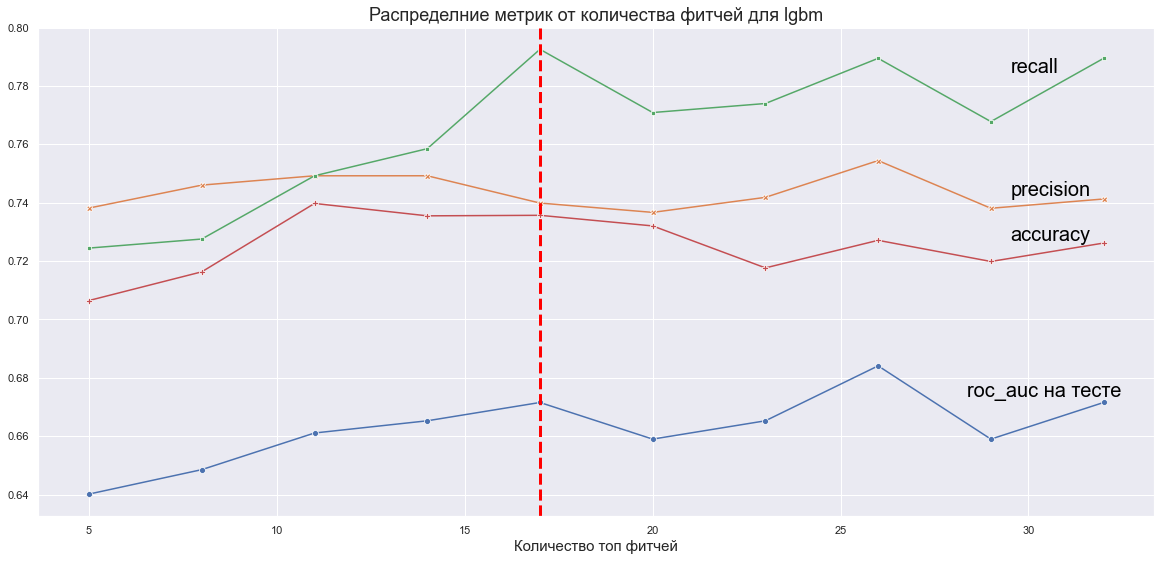

In [63]:
sns.set()
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределние метрик от количества фитчей для lgbm', fontsize=18)
axes.set_xlabel('Количество топ фитчей', fontsize=15)
sns.lineplot(data=final_result_lgbm.set_index('Кол-во топ фитчей')[['accuracy', 'precision', 'recall', 'auc_roc на тесте']], markers=True, dashes=False, legend = False)
#axes.legend(labels=["accuracy","precision", "recall","roc_auc на тесте"], fontsize=15);
f.text(0.8, 0.81, 'recall', fontsize=20,  color='black')
f.text(0.8, 0.62, 'precision', fontsize=20,  color='black')
f.text(0.8, 0.55, 'accuracy', fontsize=20,  color='black')
f.text(0.77, 0.31, 'roc_auc на тесте', fontsize=20,  color='black')
plt.axvline(17, 0, color = 'red', linestyle='--', linewidth = 3);

**Для модели LGBM лучший рузультат по метрикам смотрится начиная с 17 фитчей.**

### Исследование качества модели CatBoost в зависимости от набора фичей

In [64]:
%%time
final_result = pd.DataFrame()
for amount in range(5, 33, 3):
    X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(amount, X_train, X_test, catboost_feature_imp)
 
    result = []
    model_fitted = []
    predictions = []
    amount_result = []

    model = CatBoostClassifier(thread_count=4)
    parameters = {'learning_rate': [0.2, 0.3], 'iterations': range(100, 200, 50), 'logging_level' : ['Silent'], 
                  'max_depth': range(1, 11, 3)}
    
    
  
    grid = GridSearchCV(model, param_grid = parameters, cv = 4, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
    model = grid.fit(X_train_new, y_train)

    auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
    model_fitted.append(model)

    #вычисяем предсказания и метрики
    predicted_test = model.best_estimator_.predict(X_test_new)
    probabilities_test = model.best_estimator_.predict_proba(X_test_new)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one_test)
    accuracy = accuracy_score(y_test, predicted_test)
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    amount_result.append(amount)

    #Сохраняем метрики и параметры лучших моделей в result    
    result.append([amount, accuracy, precision, recall, auc_roc_valid, auc_roc, model.best_params_])
    #Сохраняем предсказания в predictions
    predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['Кол-во топ фитчей', 'accuracy', 'precision', 'recall', 'auc_roc на валиде', 
                                                 'auc_roc на тесте', 'Оптимальные параметры модель']) 
    
    final_result = pd.concat([final_result, result], axis = 0)
    
    #Отрисовка confusion matrix

display(final_result)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits


,Кол-во топ фитчей,accuracy,precision,recall,auc_roc на валиде,auc_roc на тесте,Оптимальные параметры модель
0,5,0.650628,0.715470,0.801858,0.750949,0.724129,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,8,0.650628,0.722857,0.783282,0.744738,0.719005,"{'iterations': 100, 'learning_rate': 0.3, 'log..."
0,11,0.652720,0.716253,0.804954,0.735306,0.717278,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,14,0.652720,0.718663,0.798762,0.730624,0.717327,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,17,0.648536,0.715877,0.795666,0.730859,0.697983,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,20,0.644351,0.721739,0.770898,0.728896,0.721522,"{'iterations': 150, 'learning_rate': 0.3, 'log..."
0,23,0.652720,0.718663,0.798762,0.724800,0.718736,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,26,0.648536,0.713499,0.801858,0.726429,0.720184,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,29,0.667364,0.727778,0.811146,0.720219,0.725217,"{'iterations': 100, 'learning_rate': 0.2, 'log..."
0,32,0.658996,0.719780,0.811146,0.718618,0.723519,"{'iterations': 100, 'learning_rate': 0.2, 'log..."


Wall time: 12min 20s


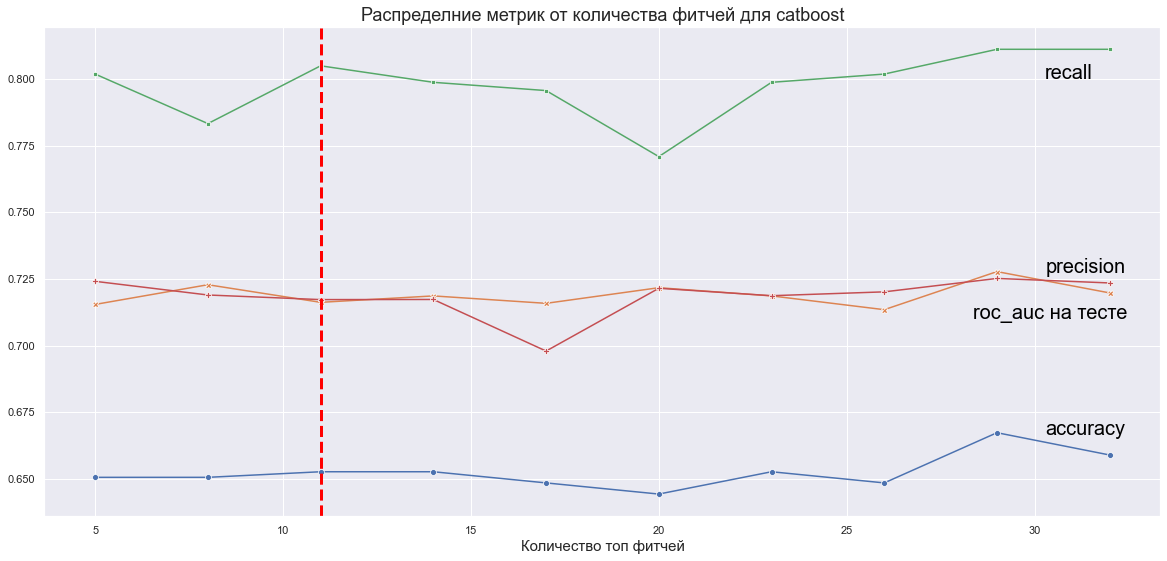

In [65]:
sns.set()
f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределние метрик от количества фитчей для catboost', fontsize=18)
axes.set_xlabel('Количество топ фитчей', fontsize=15)
sns.lineplot(data=final_result.set_index('Кол-во топ фитчей')[['accuracy', 'precision', 'recall', 'auc_roc на тесте']], markers=True, dashes=False, legend = False)
#axes.legend(labels=["accuracy","precision", "recall","roc_auc на тесте"], fontsize=15);
f.text(0.82, 0.80, 'recall', fontsize=20,  color='black')
f.text(0.82, 0.50, 'precision', fontsize=20,  color='black')
f.text(0.82, 0.25, 'accuracy', fontsize=20,  color='black')
f.text(0.77, 0.43, 'roc_auc на тесте', fontsize=20,  color='black')
plt.axvline(11, 0, color = 'red', linestyle='--', linewidth = 3);

In [66]:
%%time
final_result = pd.DataFrame()

X_train_new, X_test_new = df_generation_based_on_amount_of_top_features(25, X_train, X_test, catboost_feature_imp)
 
result = []
model_fitted = []
predictions = []
amount_result = []

model = CatBoostClassifier(thread_count=4)
parameters = {'learning_rate': [0.2, 0.3], 'iterations': range(100, 200, 50), 'logging_level' : ['Silent'], 
                  'max_depth': range(1, 11, 3)}
    
    
  
grid = GridSearchCV(model, param_grid = parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
model = grid.fit(X_train_new, y_train)

auc_roc_valid = model.best_score_

    #model = GridSearchCV(clf, param_grid = hyperparam, cv=2, scoring='roc_auc', n_jobs = -1, verbose = 2).fit(X, y)
    
    #auc_roc_valid = model.best_score_
    
model_fitted.append(model)

    #вычисяем предсказания и метрики
predicted_test = model.best_estimator_.predict(X_test_new)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Wall time: 1min 17s


[[ 57  98]
 [ 66 257]]


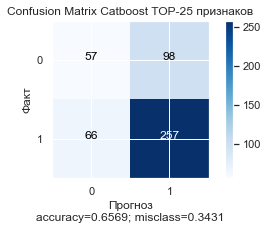

In [67]:
cm = confusion_matrix(np.array(y_test), predicted_test)
print(cm)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix Catboost TOP-25 признаков")

#importance = cb_model.feature_importances_
#res = plot_feature_importance(importance,X_train.columns,5,30)

**Для модели Catboost лучший рузультат по метрикам смотрится начиная с 25 фитчей.**

# Вывод

**В качестве целевых метрик, предалагаем использовать совокупность метрик: ROC-AUC, accuracy, precision, recall. Отдельно, каждую из этих метрик использовать сложно, так как они сложно интерпритируемы с точки зрения бизнеса.**

**Лучшие метрики получены на моделях градиентного бустинга CatboostClassifier, LGBMClassifier. Видно, что из всех опробованных моделей "победил" CatBoost. Метрики на LGBMClassifier незначительно уступают метрикам на CatBoostClassifier.**

**Также в данном проекте мы рассмотрели возможность анализа признаков, которые больше всего влияют на результат предсказания. Для этого использовали метод permature importance библиотеки sklearn. Модель CatboostClassifier имеет большое преимущество перед LGBMClassifeir в вилу возможности использования ТОП-15 признаков, что значительно ускоряет работу даннйо модели и незначительно влияет на итоговые метрики.**